To fit the exported UV melting files, QC, append data to a standard format table, and make analysis plots.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import os, json
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from nnn.uv import *

In [2]:
datadir = '/mnt/d/data/nnn/ECLExport'
for fn in absolute_file_paths(datadir):
    print(fn)

/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/1_CoolingCurve.csv
/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/1_MeltingCurve.csv
/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/1_SecondaryCoolingCurve.csv
/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/1_SecondaryMeltingCurve.csv
/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/2_CoolingCurve.csv
/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/2_MeltingCurve.csv
/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/2_SecondaryCoolingCurve.csv
/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/2_SecondaryMeltingCurve.csv
/mnt/d/data/nnn/ECLExport/220712_WC2378_hairpin_1M-Na_conc_test/4_CoolingCurve.csv
/mnt/d/data/nnn/ECLExport/220712_WC2378_hairpin_1M-Na_conc_test/4_MeltingCurve.csv
/mnt/d/data/nnn/ECLExport/220712_WC2378_hairpin_1M-Na_conc_test/4_SecondaryCoolingCurve.csv
/mnt/d/data/nnn/ECLExport/220712_WC2378_hairpin_1M-Na_conc_test/4_SecondaryMeltingCurve.csv
/mnt/d/data/nnn/ECLExport/220712_WC2378_hairpin_1M-Na_conc_tes

In [5]:
data_list = list(absolute_file_paths(datadir))

In [13]:
summary_table = pd.read_table('/mnt/d/data/nnn/SummaryUVMeltingExperiments.tsv')
summary_table = summary_table.query('Usable').drop(columns=['ProtocolID','Usable','PrepareFresh'])
summary_table['DateCompleted'] = summary_table['DateCompleted'].apply(lambda x: ''.join(x.split('-'))[2:])

DateCompleted                        Description  \
0         220526                   SL001_1M-Na_test   
2         220712     WC2378_hairpin_1M-Na_conc_test   
3         220727       WC68_hairpin_1M-Na_conc_test   
4         220809            WC_batch1_hairpin_1M-Na   
5         220828          WC_batch1_hairpin_50mM-Na   
8         220904          WC_batch1_hairpin_25mM-Na   
9         220908          WC_batch2_hairpin_25mM-Na   
13        221013  WC1025_duplex_25mM-Na_higher_conc   

                                                Oligo OligoConcentrationuM  \
0                                               SL001            4,2,1,0.5   
2                                              WC2378   128,64,32,16,8,4,2   
3                                                WC68      1,2,4,5,8,10,12   
4      WC1106,WC1048,WC1394,WC200,WC578,WC1025,WC1154                  6.4   
5       WC1048,WC1394,WC200,WC578,WC1025,WC1154,WC788                  6.4   
8       WC1048,WC1394,WC200,WC578,WC1025,WC1154,WC788                  3.2   
9       WC788,WC1432,WC1203,WC2922,WC91,WC2119,WC2215                  3.2   
13  WC1025_stem,WC1025_stem,WC1025_stem,WC1025_spl...    48,72,96,48,72,96   

    NaConcmM  SnapFreeze  Blank  NumberOfCycles  MinTemperature  \
0       1000       False  False               2               5   
2       1000       False  False               2               5   
3       1000       False  False               2               5   
4       1000       False  False               2               5   
5         50        True   True               2              12   
8         25        True   True               2              12   
9         25        True   True               3              12   
13        25       False  False               2               1   

    MaxTemperature                                             Result  
0               95                                   First 2 are good  
2               95                              Those <=16uM are good  
3               95                                               Good  
4               95                                             Great!  
5               85             Some curves look funny but mostly fine  
8               85                                          OK to use  
9               85  Only some of the first melt curves were usable...  
13              45  Only the 72uM stem one works perfectly. The 48...

In [28]:
summary_table = pd.read_csv('/mnt/d/data/nnn/SummaryUVMeltingExperimentsModified.csv', index_col=0)

In [82]:
"""
Transfer into long form sample sheet
"""

sample_columns = ['curve_date', 'curve_num', 'SEQID', 'conc_uM', 'Na_mM', 'celsius_min', 'celsius_max']
sample_df = pd.DataFrame(columns=sample_columns)

for i,row in summary_table.iterrows():

    oligo_list = row['Oligo'].split(',')
    conc_list = row['OligoConcentrationuM'].split(',')
    n = max(len(oligo_list), len(conc_list))
    if len(oligo_list) == 1:
        oligo_list = [oligo_list[0] for _ in range(n)]
    if len(conc_list) == 1:
        conc_list = [conc_list[0] for _ in range(n)]
    
    if n > 1:
        for i in range(n):
            sample_dict = dict(curve_date=row['DateCompleted'],
                               curve_num=str(i+1),
                               SEQID=oligo_list[i],
                               conc_uM=conc_list[i],
                               Na_mM=row['NaConcmM'],
                               celsius_min=row['celsiusMin'],
                               celsius_max=row['celsiusMax']
                              )
            
            sample_df = pd.concat((sample_df, pd.DataFrame(pd.Series(sample_dict)).T),
                                  ignore_index=True)
            
sample_df.to_csv('/mnt/d/data/nnn/UVMeltingSampleSheet.csv')

In [83]:
sample_df.curve_date = sample_df.curve_date.astype(str)

curve_date curve_num         SEQID conc_uM Na_mM celsius_min celsius_max
0      220526         1         SL001       4  1000           5          60
1      220526         2         SL001       2  1000           5          60
2      220526         3         SL001       1  1000           5          60
3      220526         4         SL001     0.5  1000           5          60
4      220712         1        WC2378     128  1000           5          80
5      220712         2        WC2378      64  1000           5          80
6      220712         3        WC2378      32  1000           5          80
7      220712         4        WC2378      16  1000           5          80
8      220712         5        WC2378       8  1000           5          80
9      220712         6        WC2378       4  1000           5          80
10     220712         7        WC2378       2  1000           5          80
11     220727         1          WC68       1  1000          20          95
12     220727         2          WC68       2  1000          20          95
13     220727         3          WC68       4  1000          20          95
14     220727         4          WC68       5  1000          20          95
15     220727         5          WC68       8  1000          20          95
16     220727         6          WC68      10  1000          20          95
17     220727         7          WC68      12  1000          20          95
18     220809         1        WC1106     6.4  1000           5          85
19     220809         2        WC1048     6.4  1000           5          85
20     220809         3        WC1394     6.4  1000           5          85
21     220809         4         WC200     6.4  1000           5          85
22     220809         5         WC578     6.4  1000           5          85
23     220809         6        WC1025     6.4  1000           5          85
24     220809         7        WC1154     6.4  1000           5          85
25     220828         1        WC1048     6.4    50           5          70
26     220828         2        WC1394     6.4    50           5          70
27     220828         3         WC200     6.4    50           5          70
28     220828         4         WC578     6.4    50           5          70
29     220828         5        WC1025     6.4    50           5          70
30     220828         6        WC1154     6.4    50           5          70
31     220828         7         WC788     6.4    50           5          70
32     220904         1        WC1048     3.2    25          12          70
33     220904         2        WC1394     3.2    25          12          70
34     220904         3         WC200     3.2    25          12          70
35     220904         4         WC578     3.2    25          12          70
36     220904         5        WC1025     3.2    25          12          70
37     220904         6        WC1154     3.2    25          12          70
38     220904         7         WC788     3.2    25          12          70
39     220908         1         WC788     3.2    25          40          60
40     220908         2        WC1432     3.2    25          40          60
41     220908         3        WC1203     3.2    25          40          60
42     220908         4        WC2922     3.2    25          40          60
43     220908         5          WC91     3.2    25          40          60
44     220908         6        WC2119     3.2    25          40          60
45     220908         7        WC2215     3.2    25          40          60
46     221013         1   WC1025_stem      48    25           0          45
47     221013         2   WC1025_stem      72    25           0          45
48     221013         3   WC1025_stem      96    25           0          45
49     221013         4  WC1025_split      48    25           0          45
50     221013         5  WC1025_split      72    25           0          45
51     221013         6  WC1025_split      96    25

## uv.py

In [260]:
from nnn.uv import *

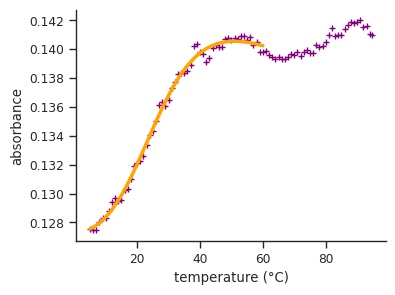

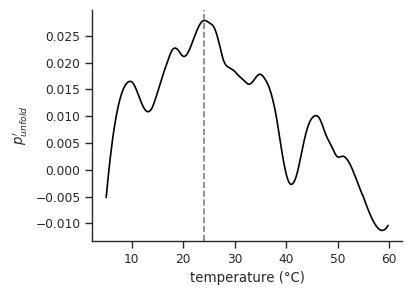

In [293]:
fn = '/mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/2_MeltingCurve.csv'
result_dict = fit_curve(fn, figdir=os.path.join(datadir, 'fig'), celsius_max=60)

In [286]:
result_df.append(result_dict, ignore_index=True)

curve_date curve_num    curve_name     dH_fit  dH_fit_std    Tm_fit  \
0     220526         1  CoolingCurve -30.368495    0.677792  27.01489   

   Tm_fit_std  fmax_fit  fmax_fit_std  fmin_fit  fmin_fit_std  slope_fit  \
0    0.065785  0.309977      0.000802  0.280776      0.000083   0.000161   

   slope_fit_std    Tm         dH        dS     dG_37 celsius_min celsius_max  
0       0.000014  24.1 -34.119267 -0.114783  1.480702         NaN          60

In [78]:
curve_name = parse_curve_name(fn)

In [109]:
sample_df.curve_date = sample_df.curve_date.astype(str)

In [135]:
row.shape

(0, 7)

220526_1_CoolingCurve
220526_1_MeltingCurve
Trouble with /mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/1_SecondaryCoolingCurve.csv
Trouble with /mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/1_SecondaryMeltingCurve.csv
220526_2_CoolingCurve
220526_2_MeltingCurve
Trouble with /mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/2_SecondaryCoolingCurve.csv
Trouble with /mnt/d/data/nnn/ECLExport/220526_SL001_1M-Na_test/2_SecondaryMeltingCurve.csv
220712_4_CoolingCurve
220712_4_MeltingCurve
220712_4_SecondaryCoolingCurve
220712_4_SecondaryMeltingCurve
220712_5_CoolingCurve
220712_5_MeltingCurve
220712_5_SecondaryCoolingCurve
220712_5_SecondaryMeltingCurve
220712_6_CoolingCurve
220712_6_MeltingCurve
220712_6_SecondaryCoolingCurve
220712_6_SecondaryMeltingCurve
220712_7_CoolingCurve
220712_7_MeltingCurve
220712_7_SecondaryCoolingCurve
220712_7_SecondaryMeltingCurve
220727_1_CoolingCurve
220727_1_MeltingCurve
220727_1_SecondaryCoolingCurve
220727_1_SecondaryMeltingCurve
220727_2_CoolingCu

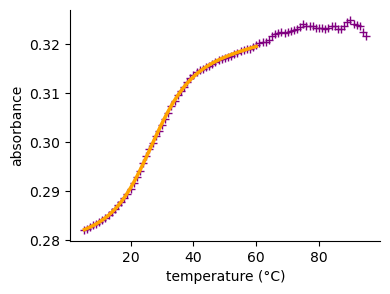

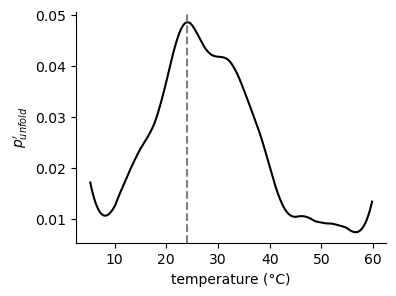

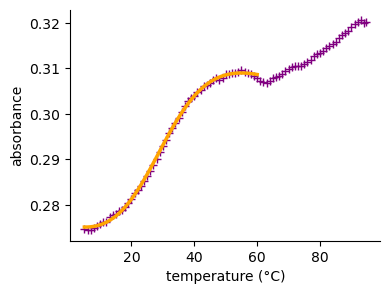

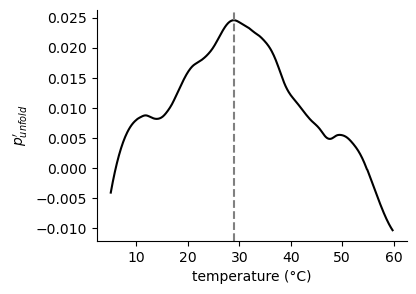

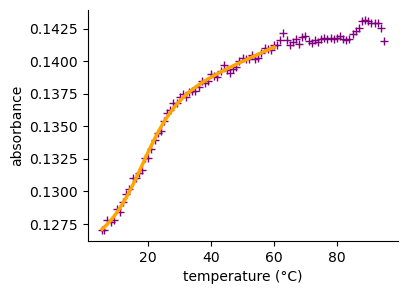

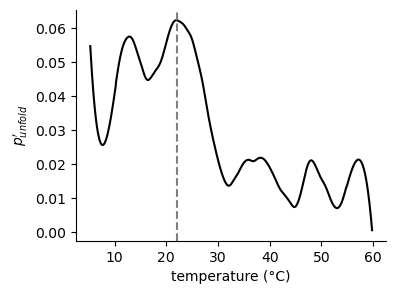

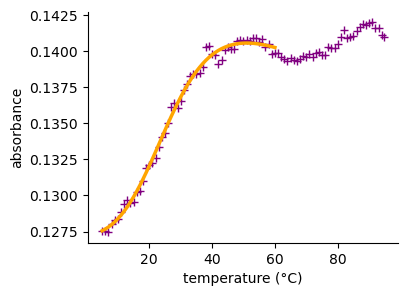

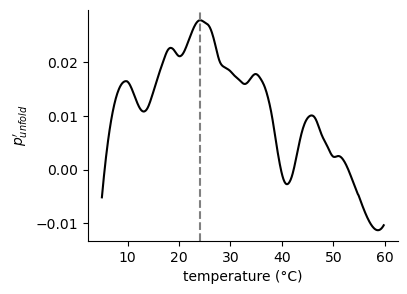

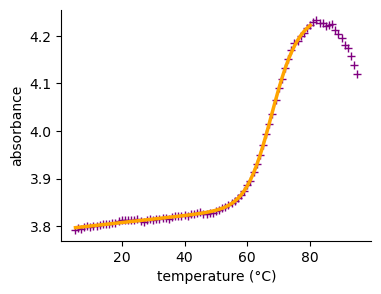

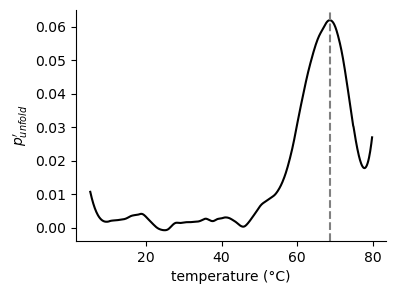

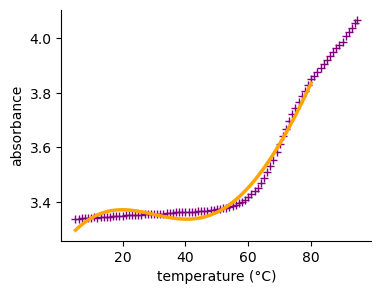

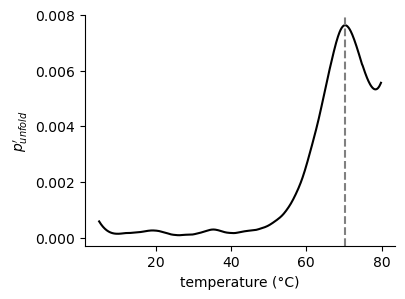

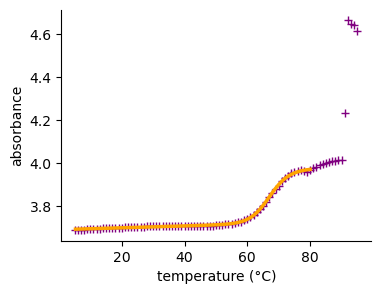

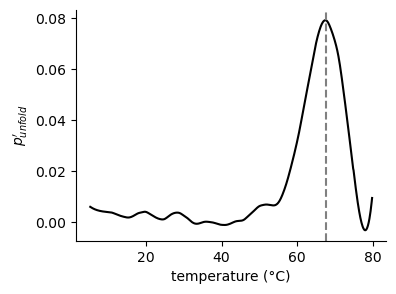

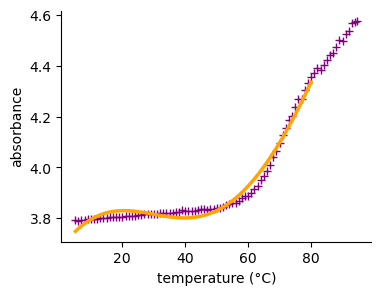

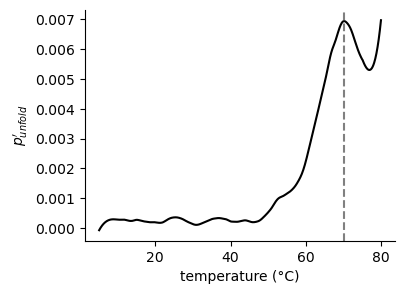

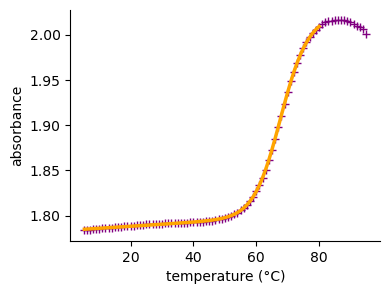

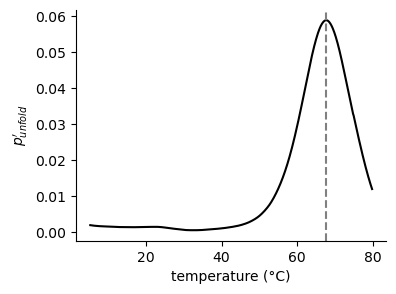

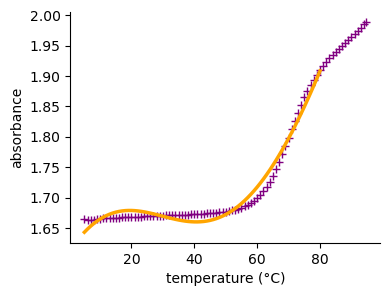

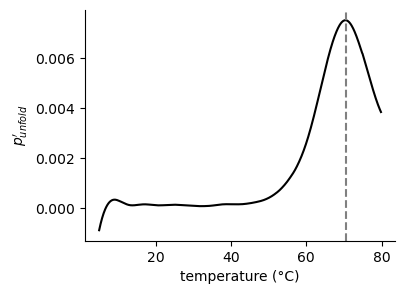

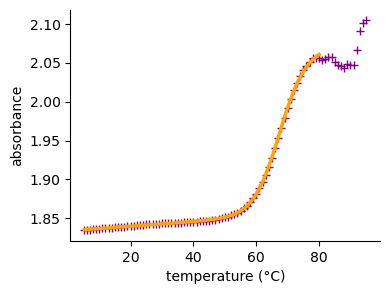

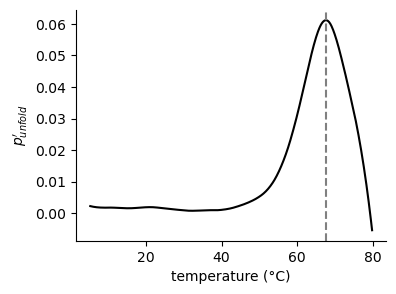

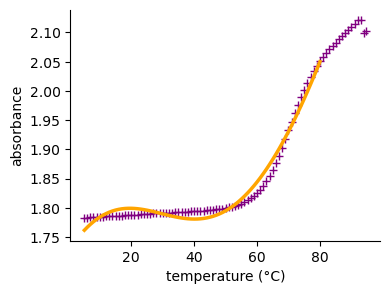

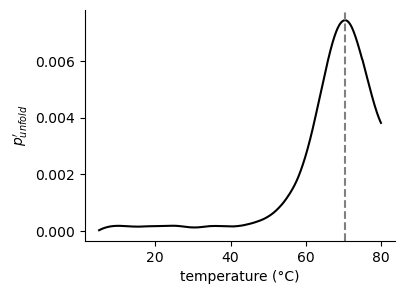

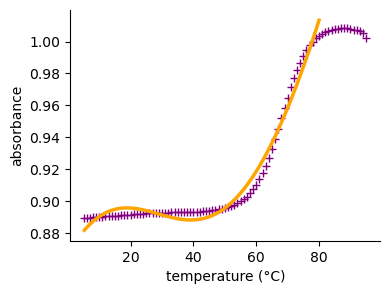

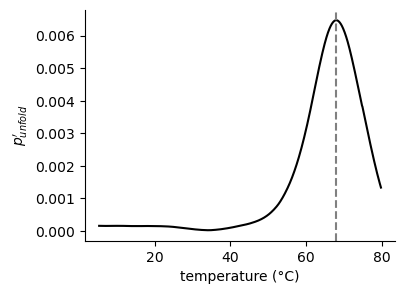

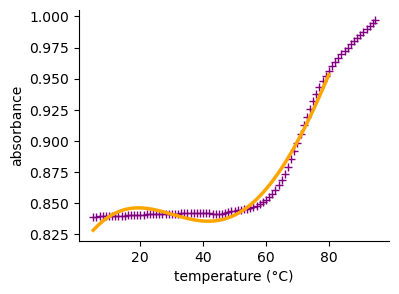

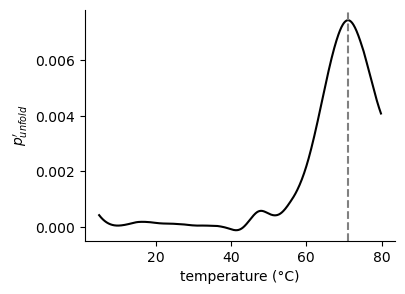

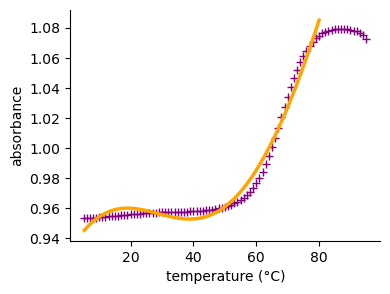

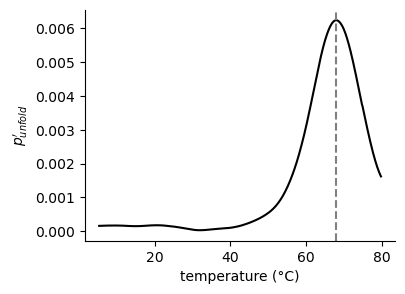

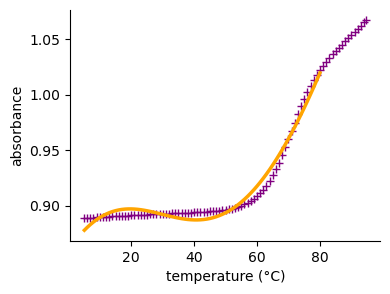

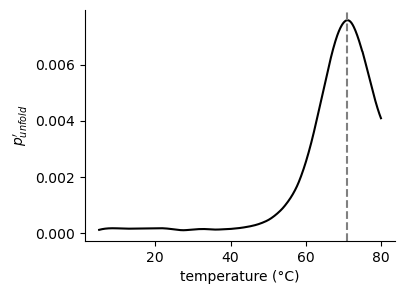

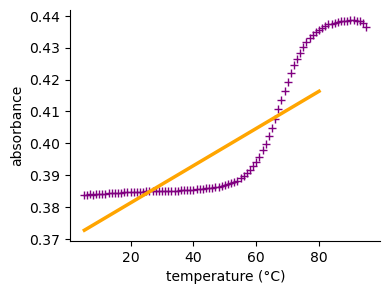

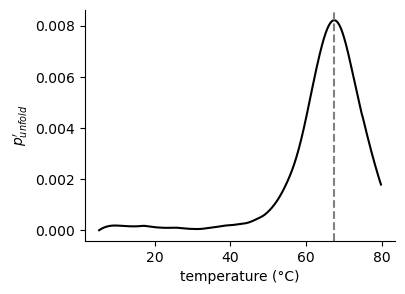

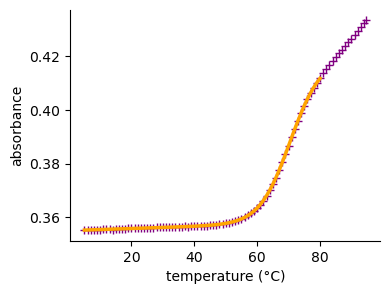

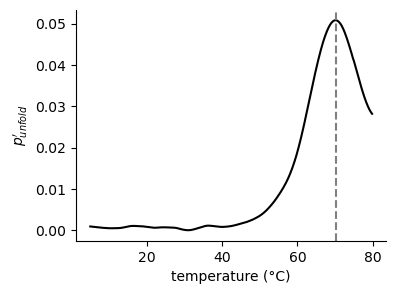

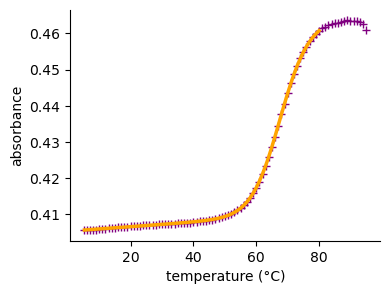

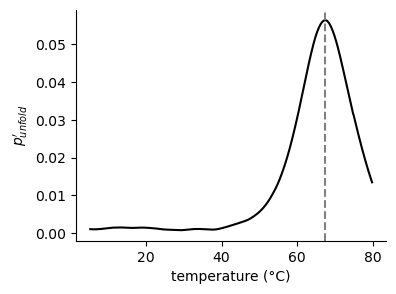

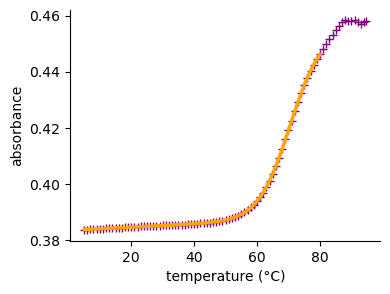

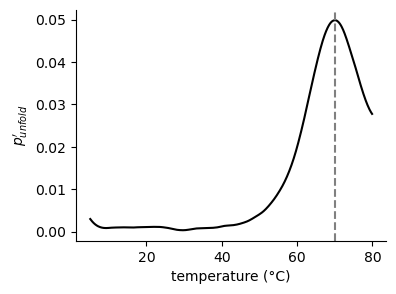

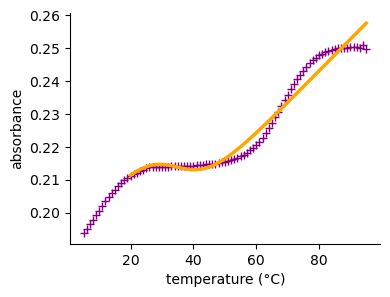

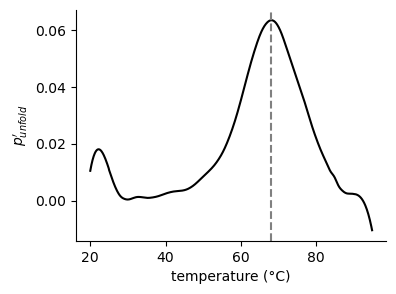

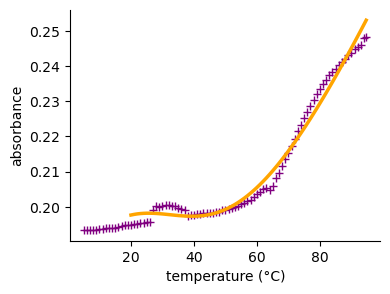

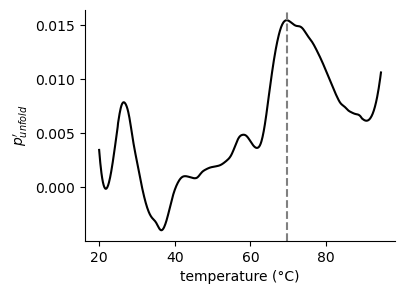

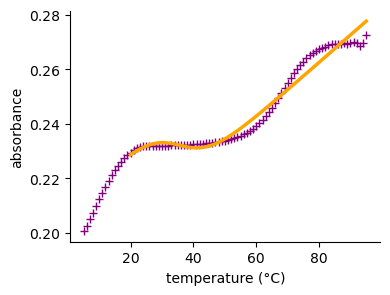

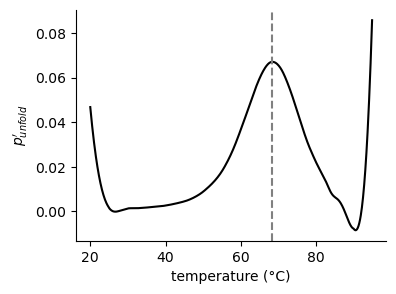

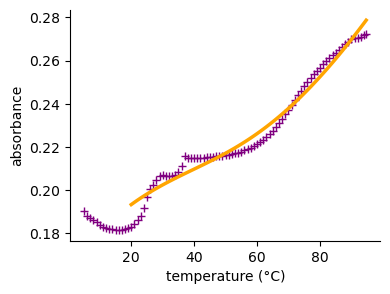

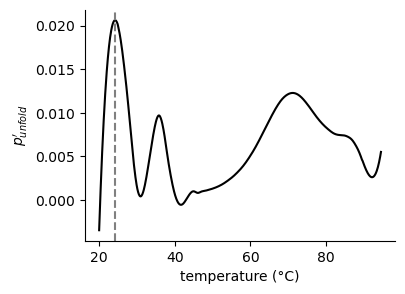

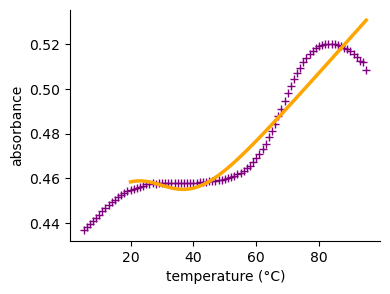

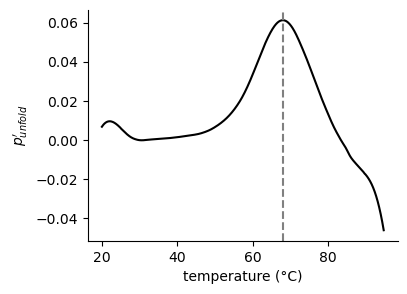

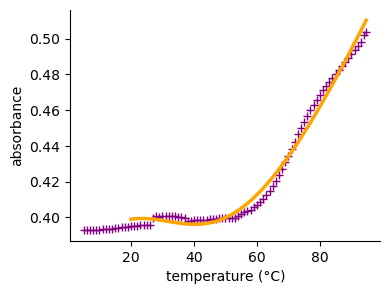

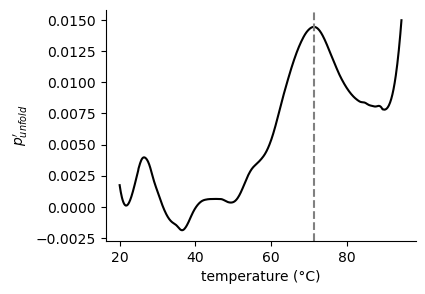

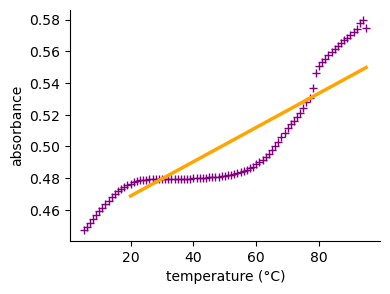

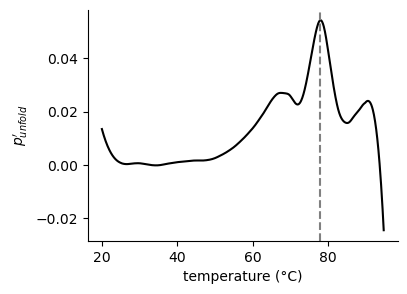

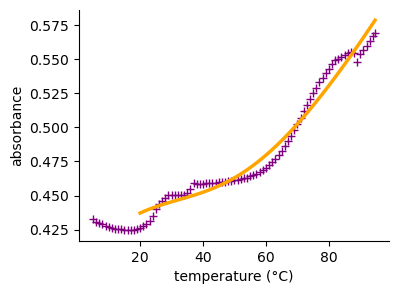

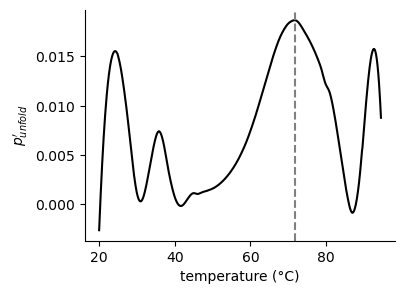

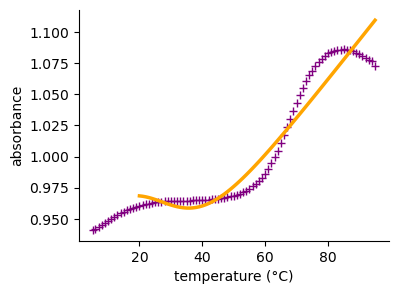

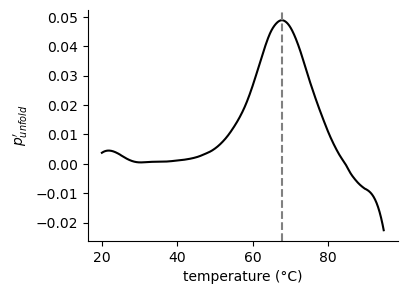

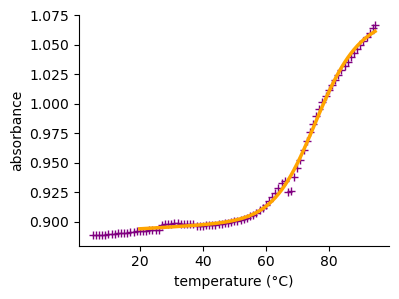

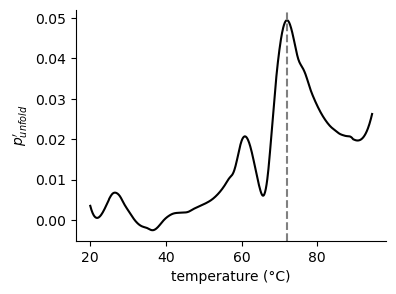

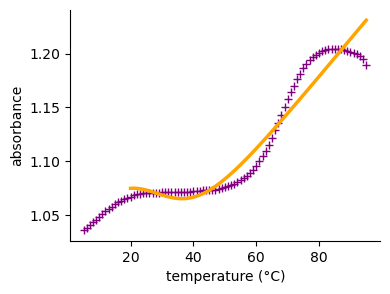

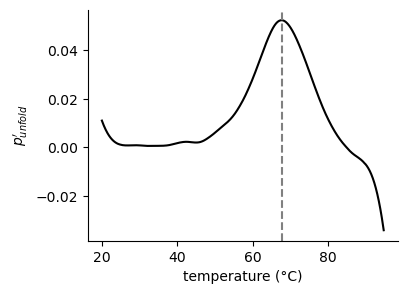

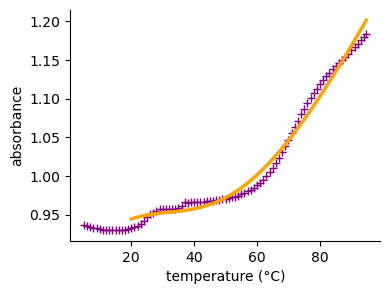

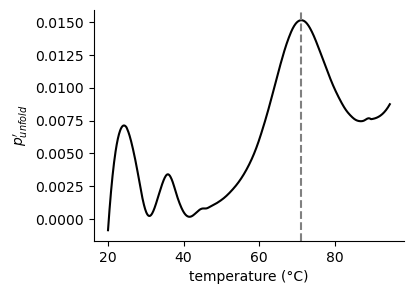

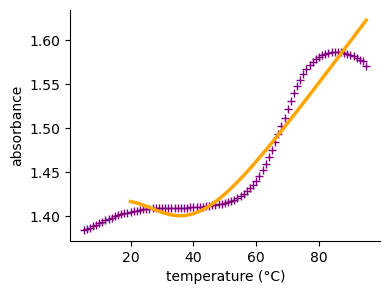

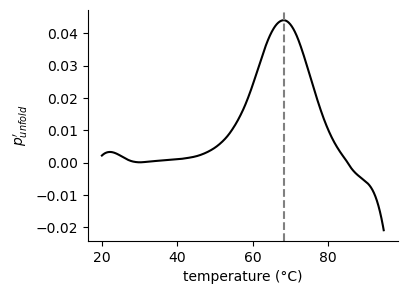

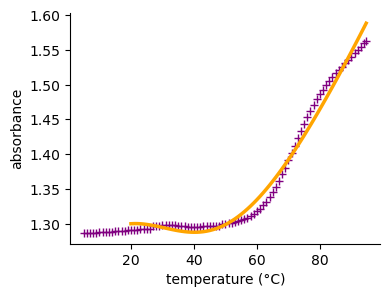

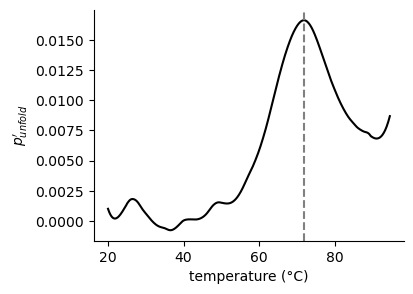

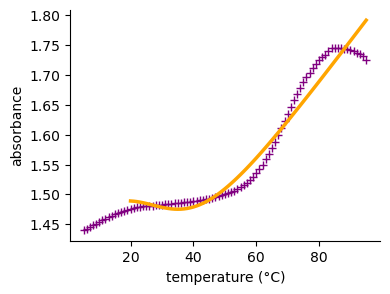

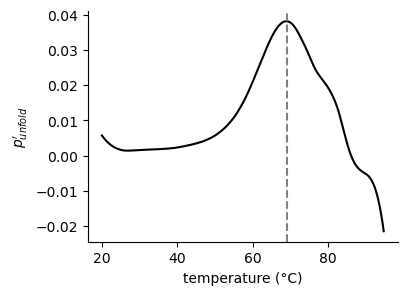

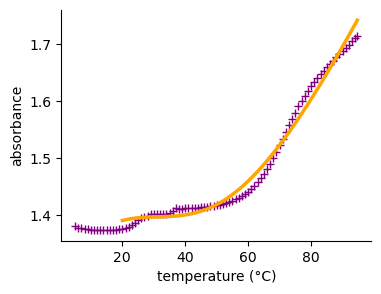

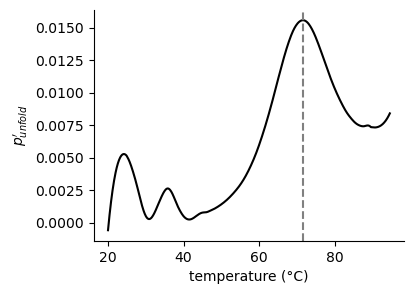

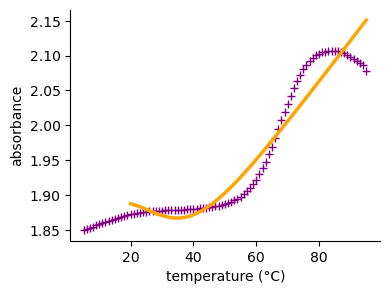

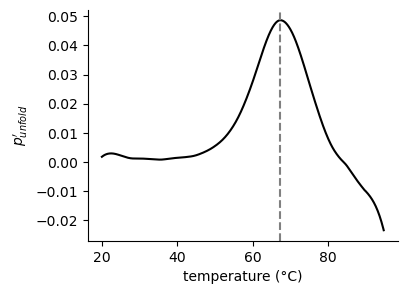

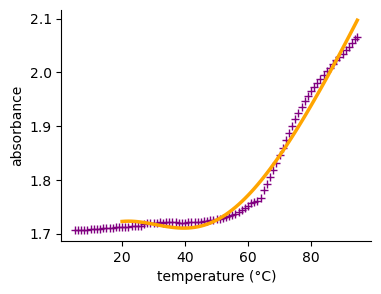

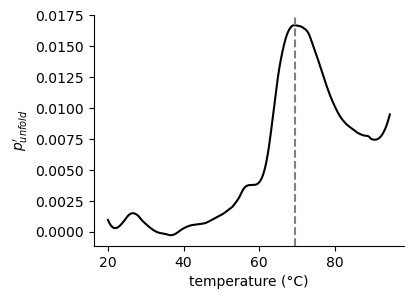

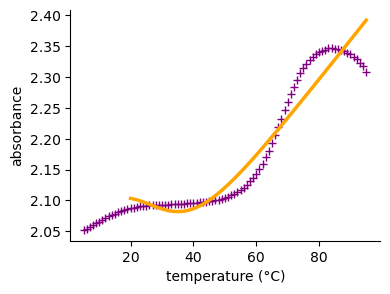

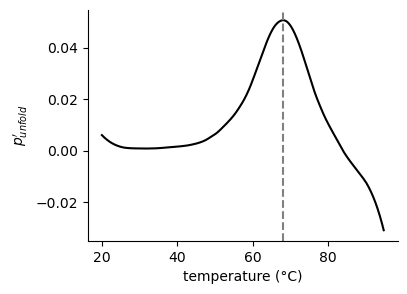

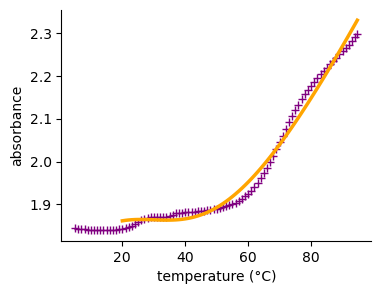

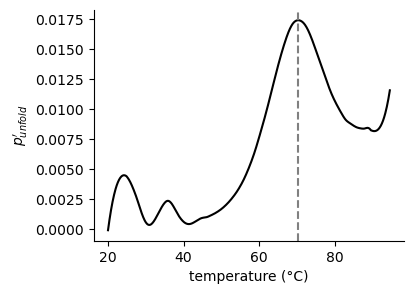

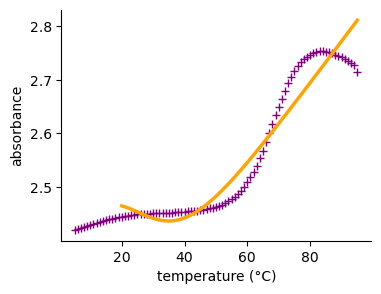

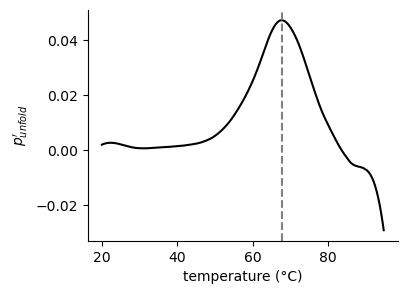

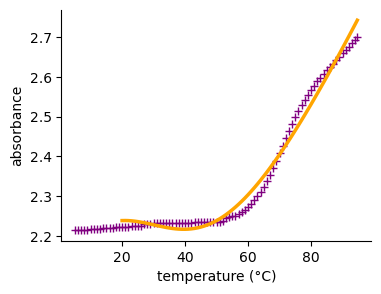

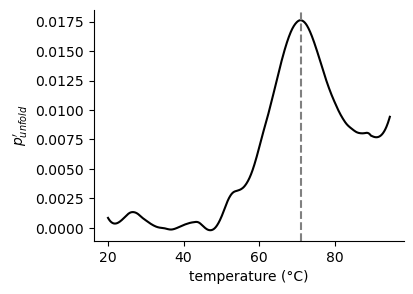

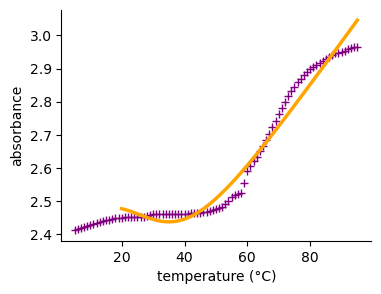

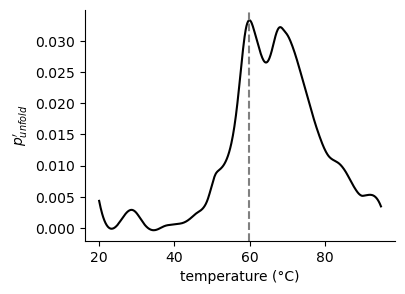

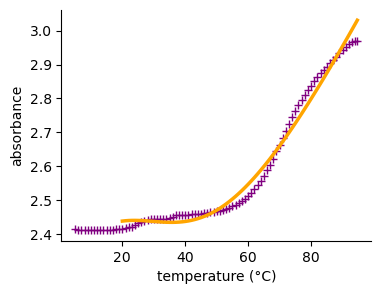

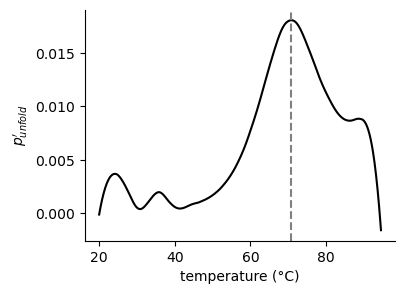

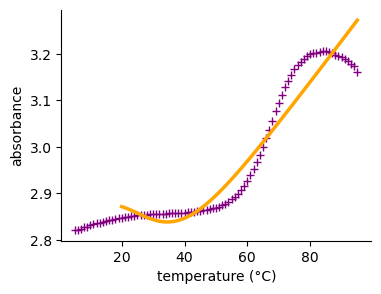

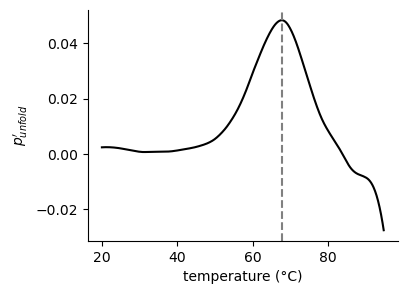

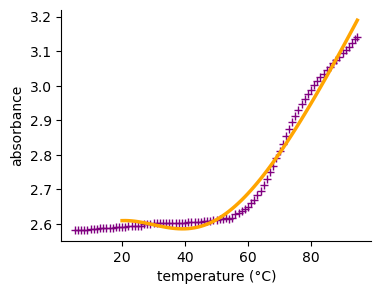

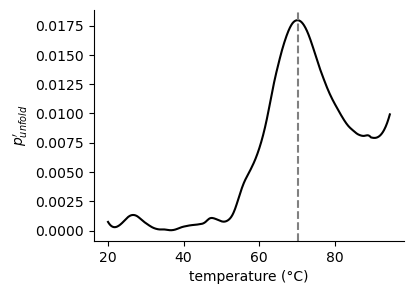

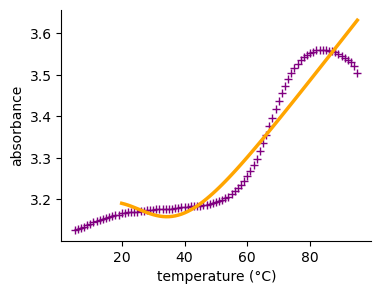

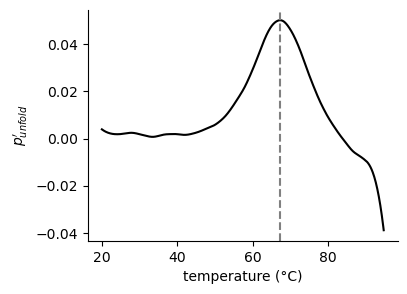

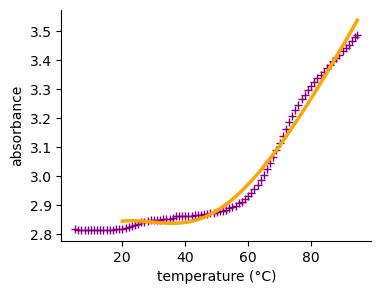

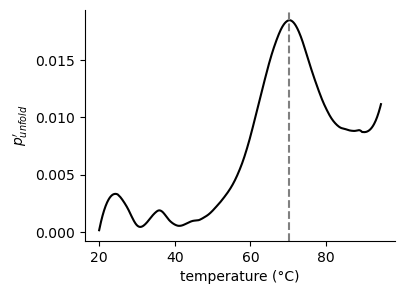

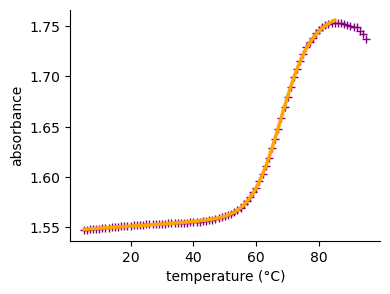

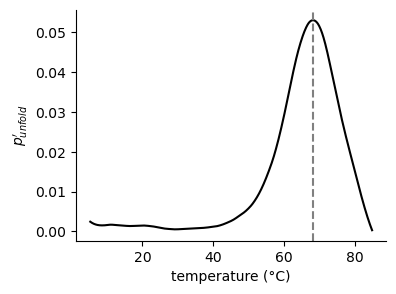

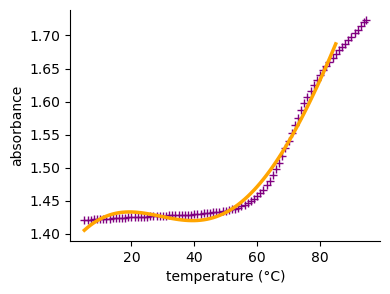

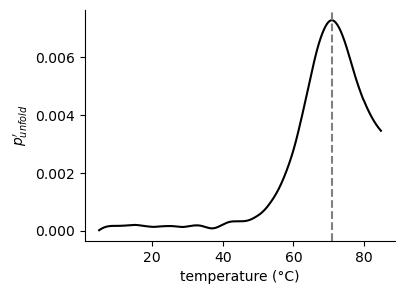

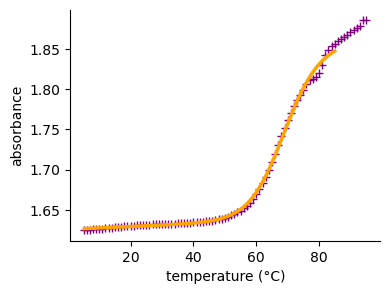

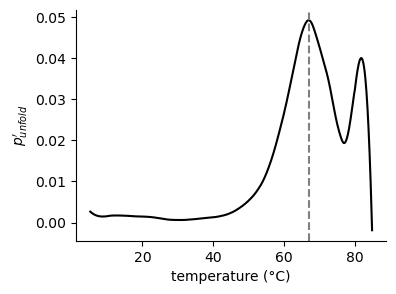

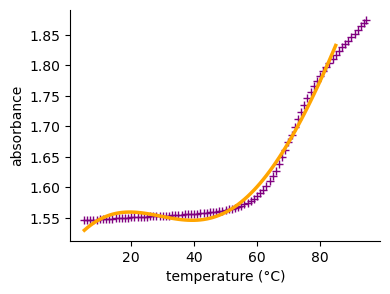

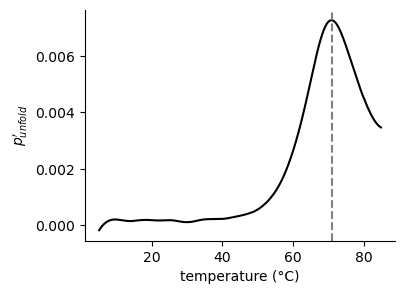

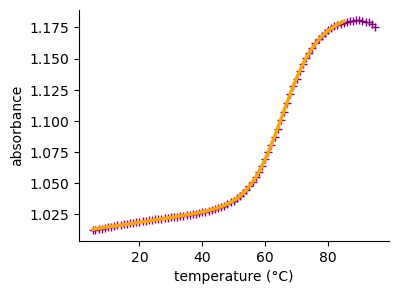

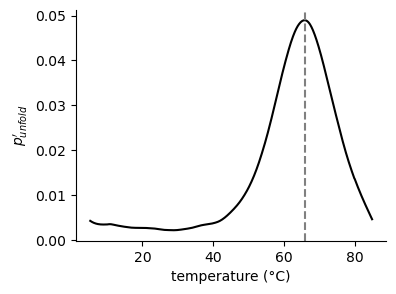

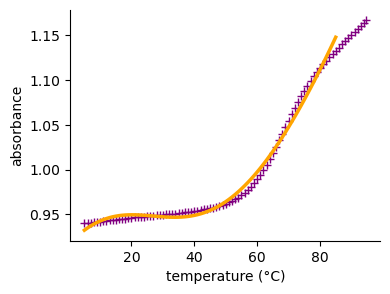

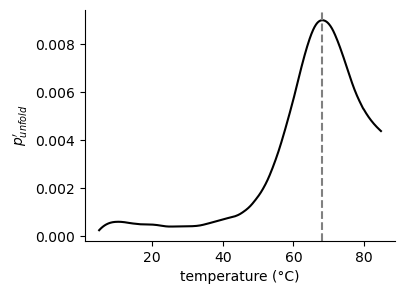

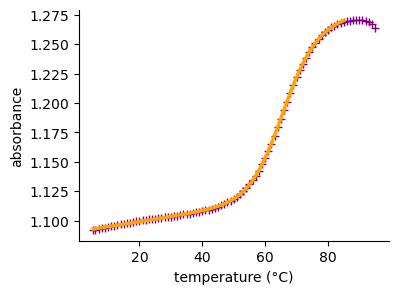

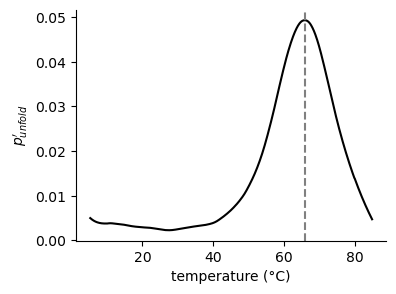

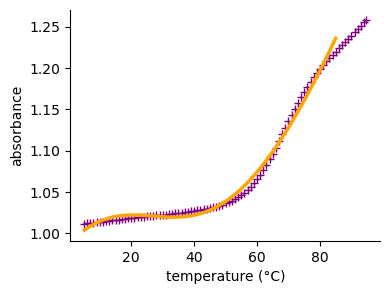

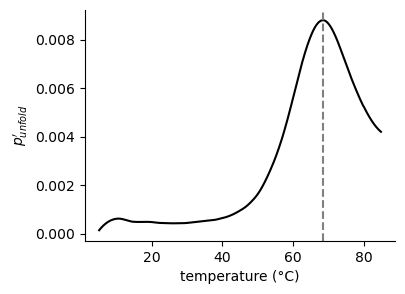

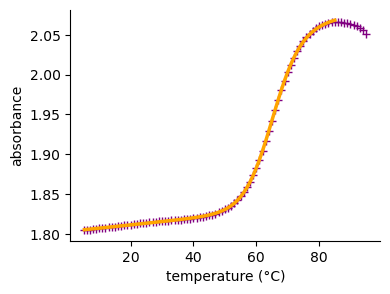

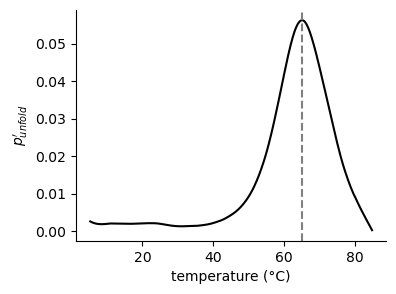

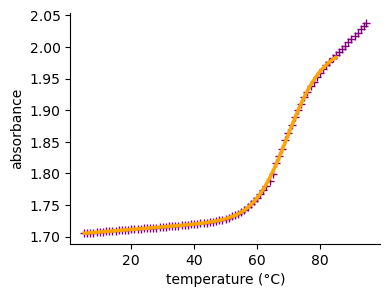

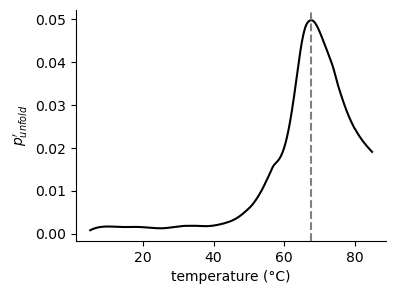

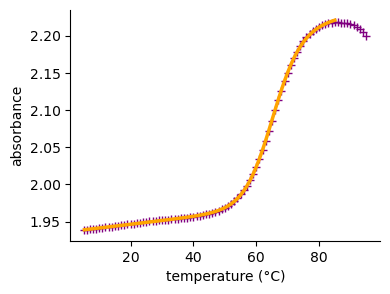

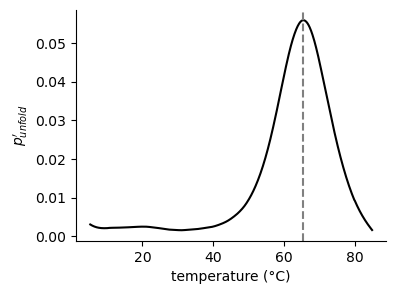

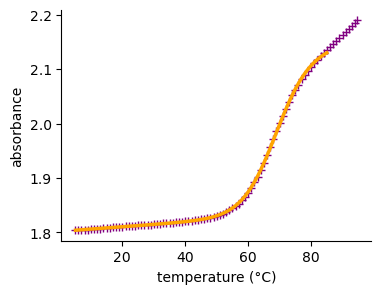

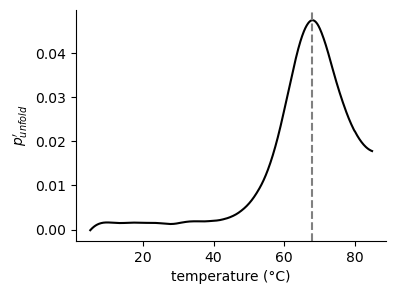

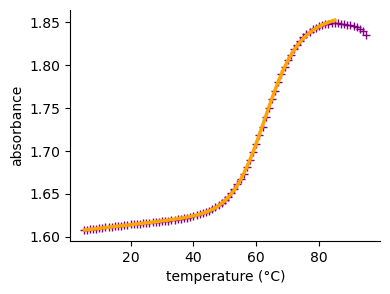

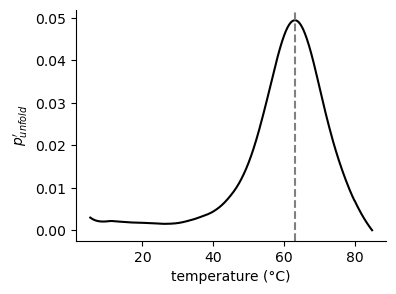

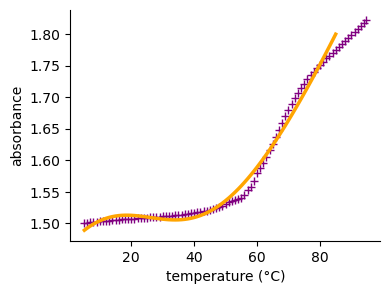

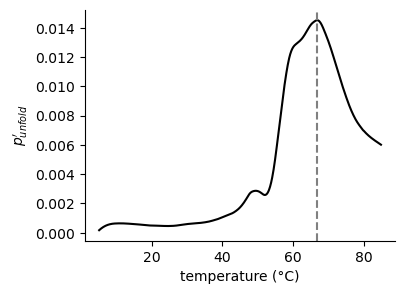

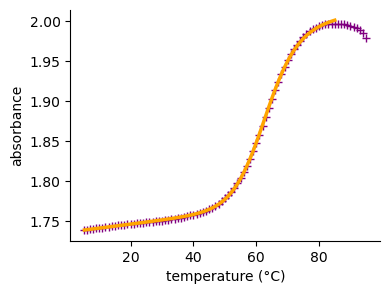

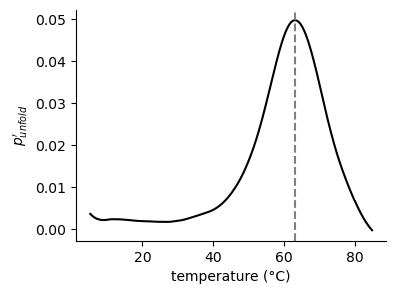

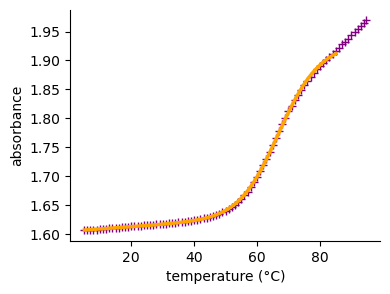

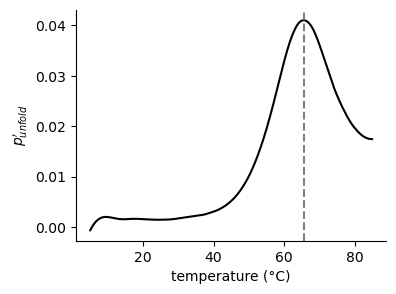

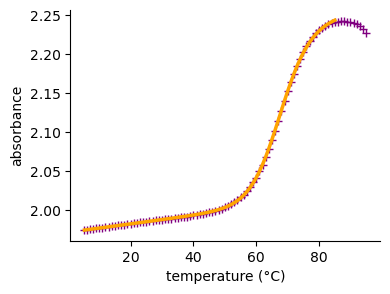

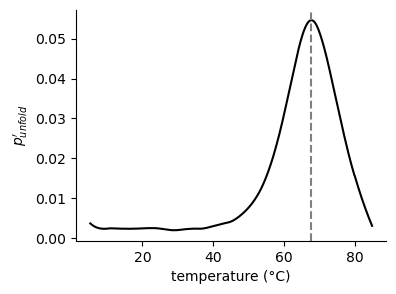

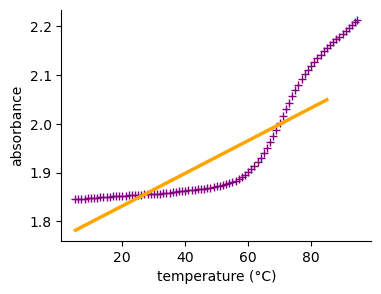

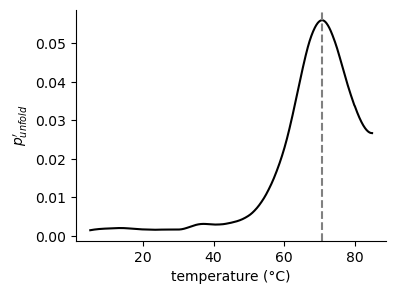

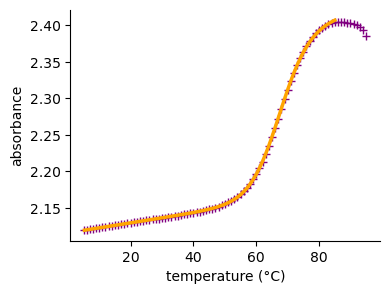

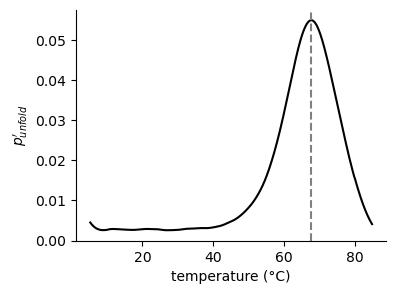

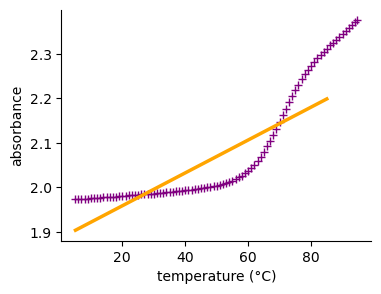

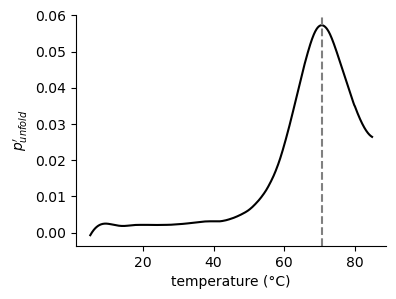

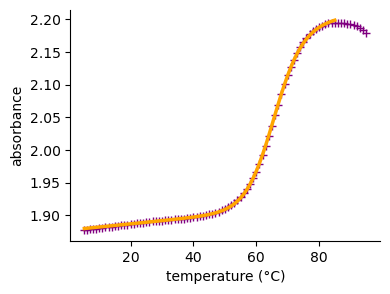

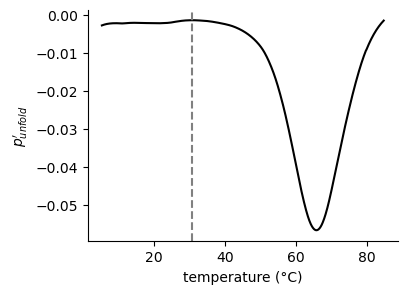

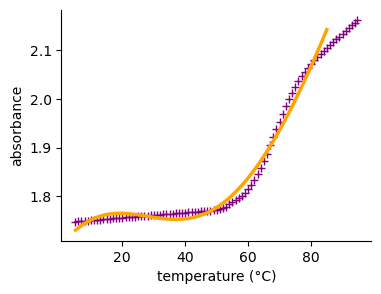

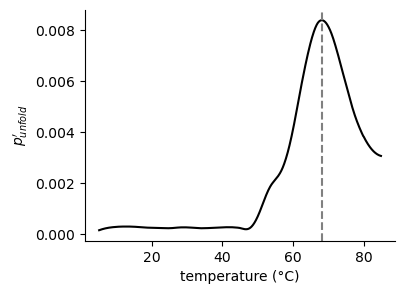

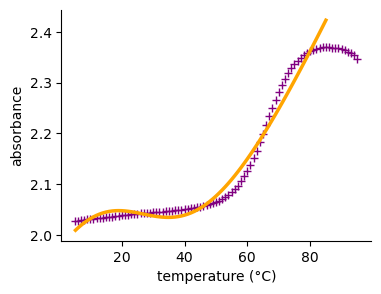

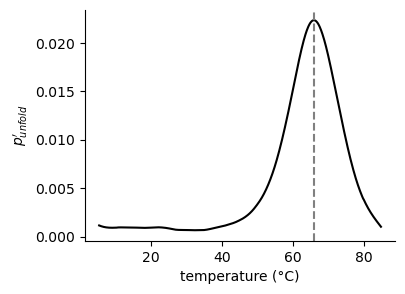

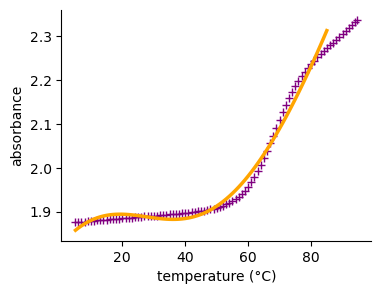

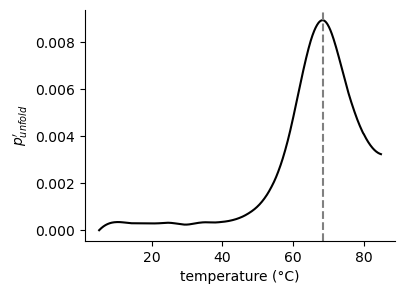

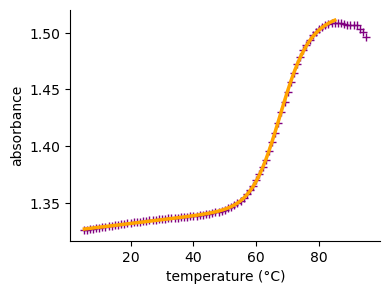

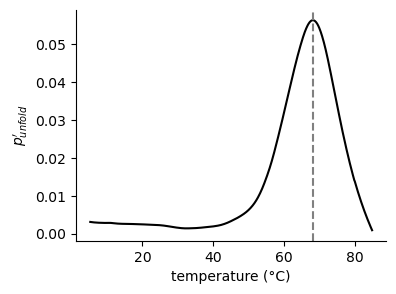

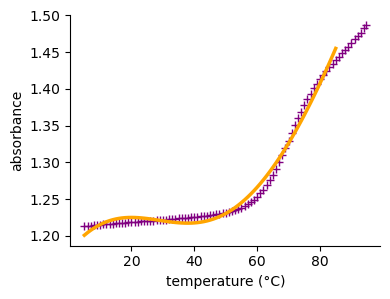

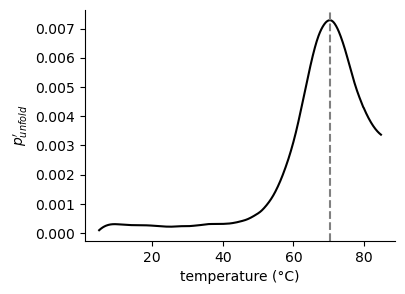

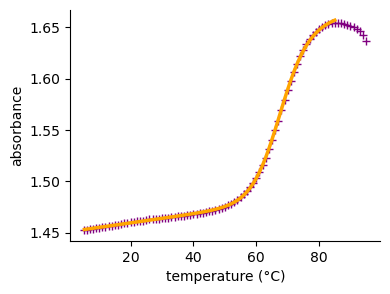

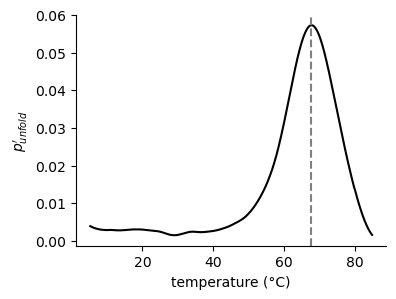

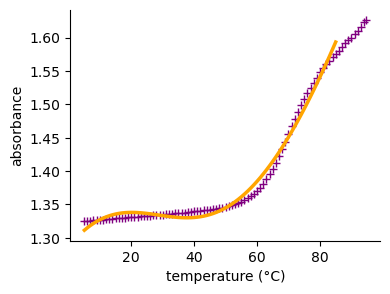

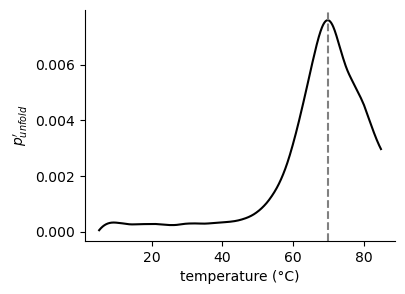

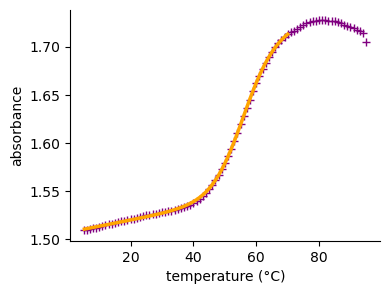

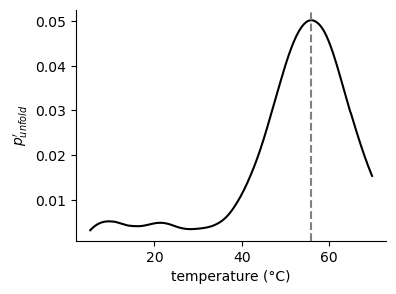

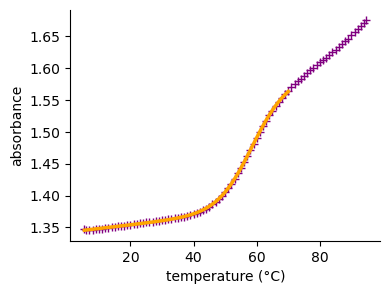

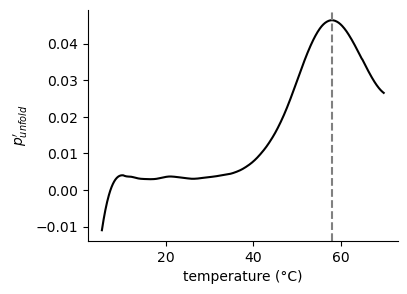

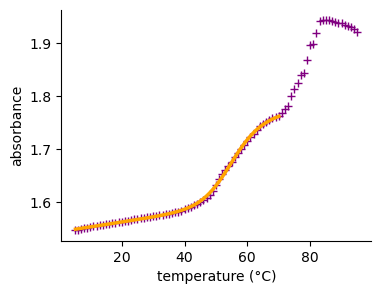

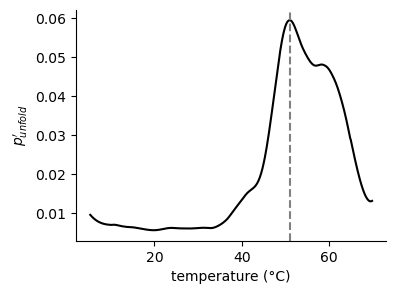

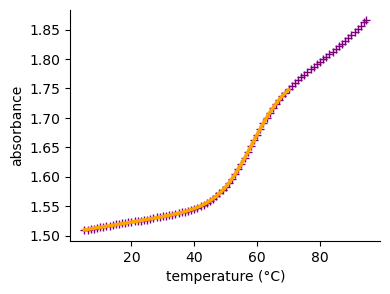

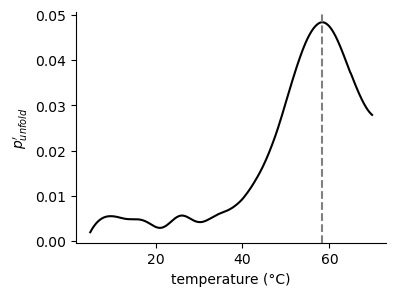

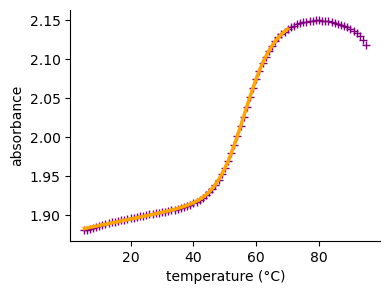

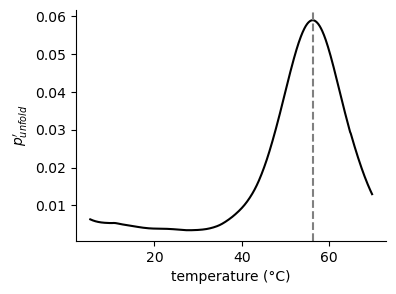

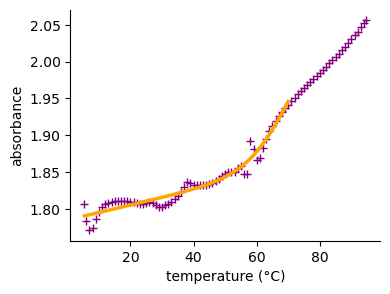

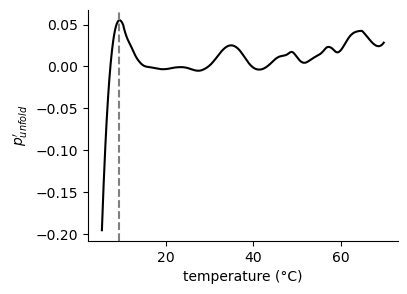

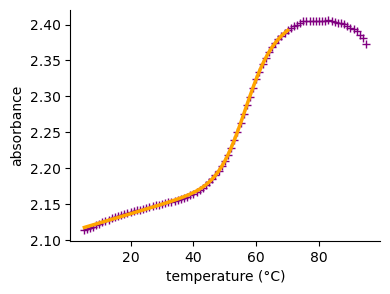

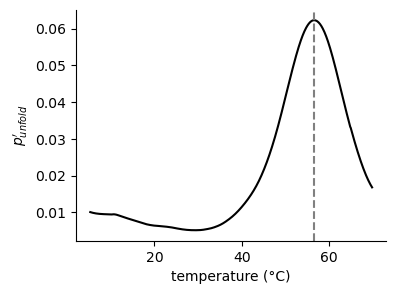

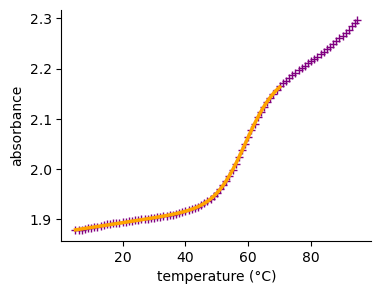

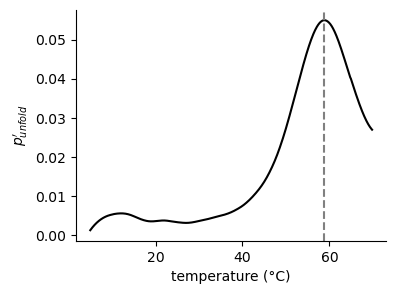

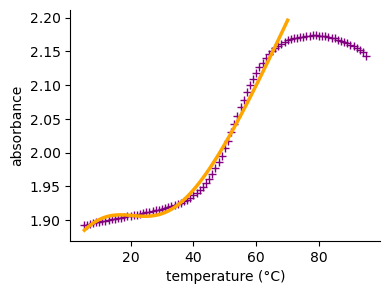

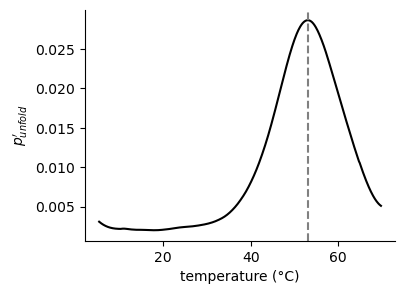

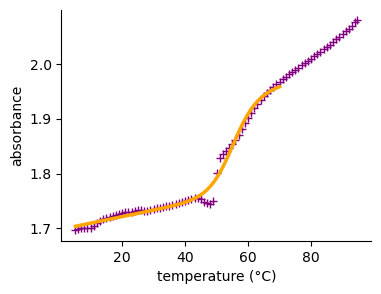

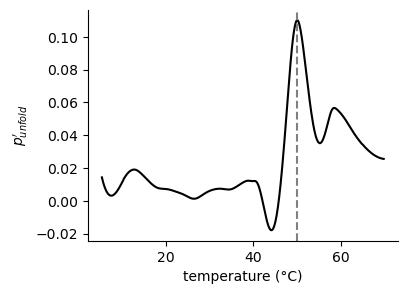

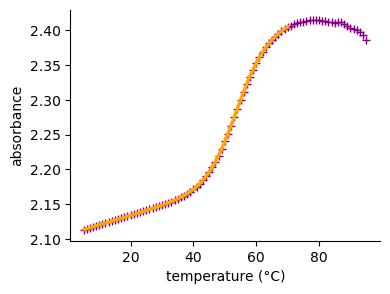

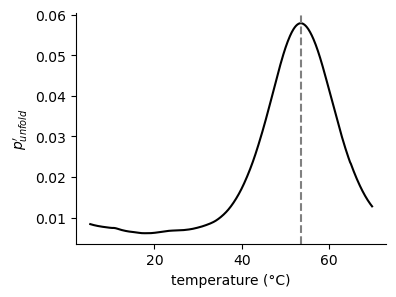

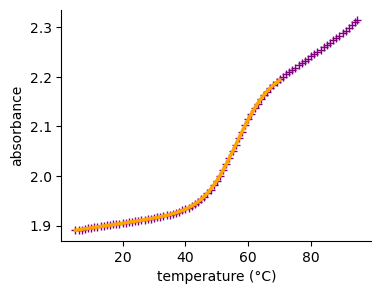

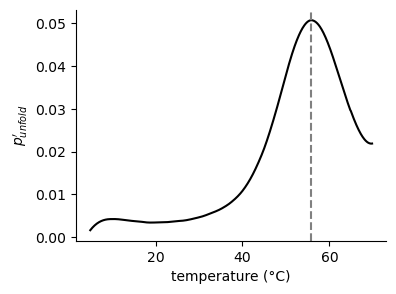

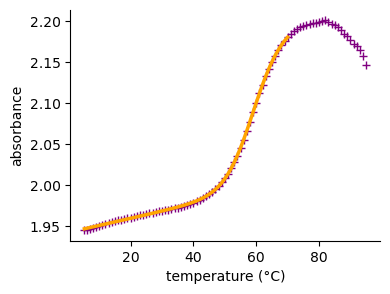

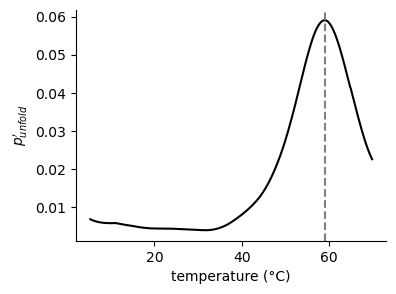

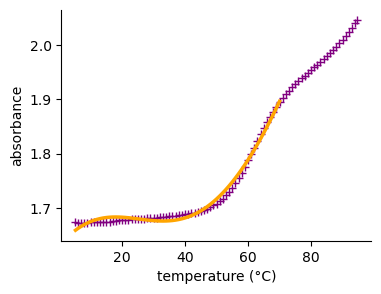

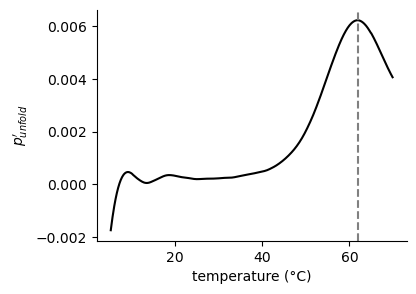

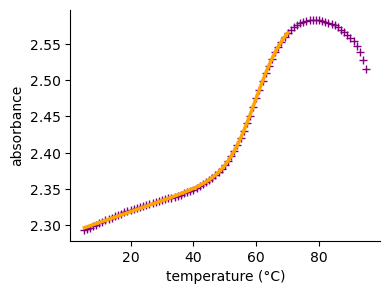

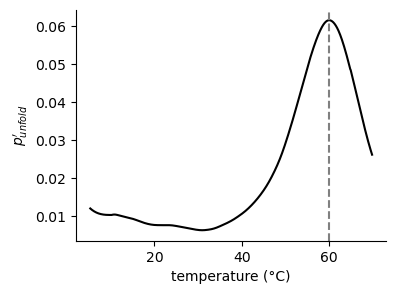

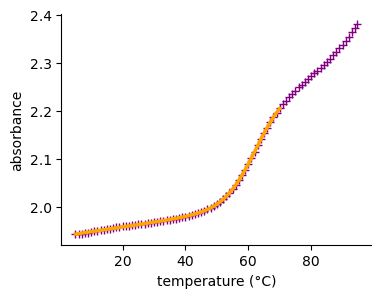

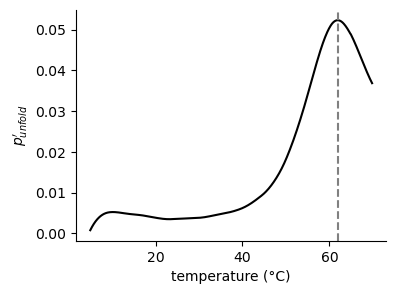

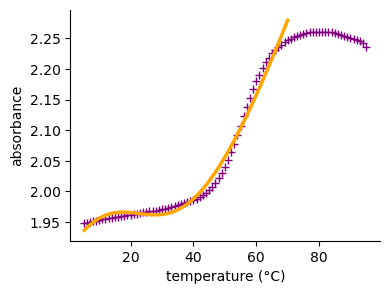

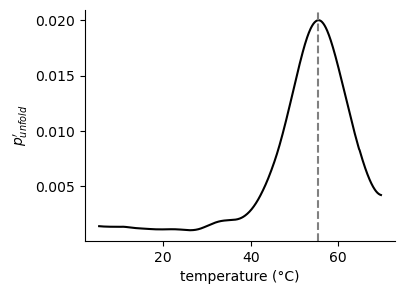

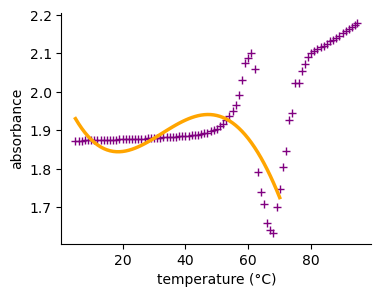

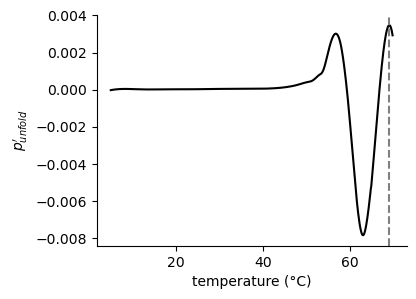

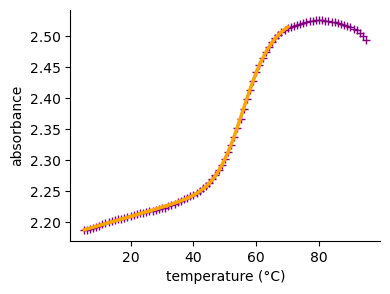

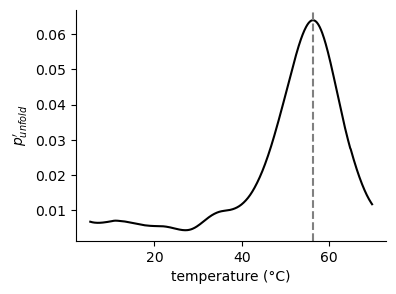

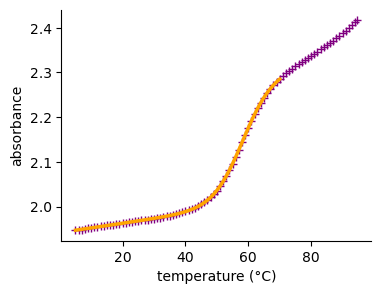

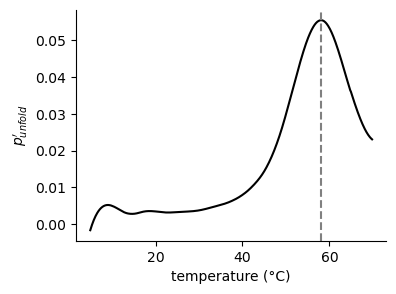

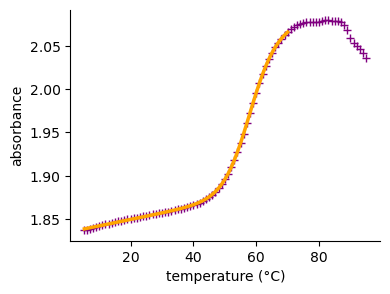

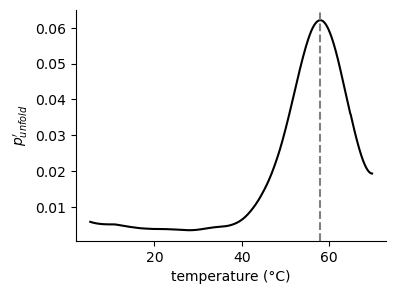

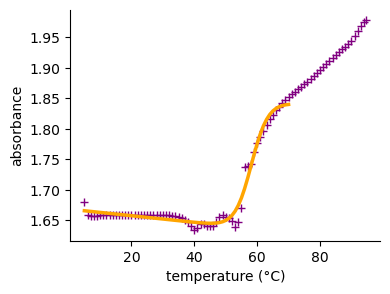

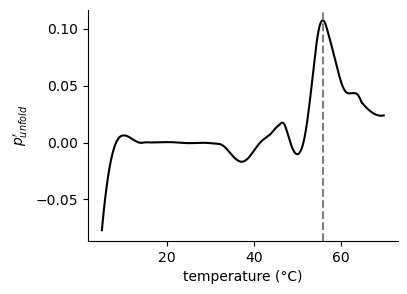

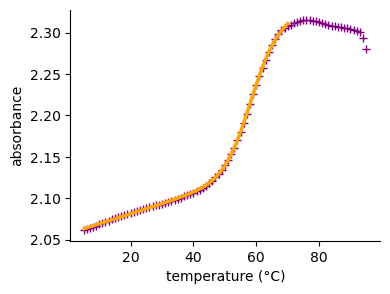

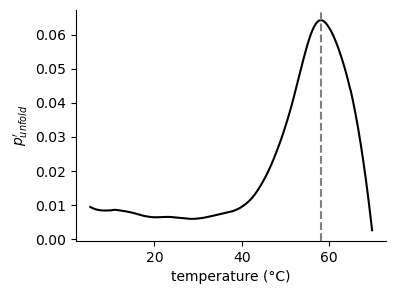

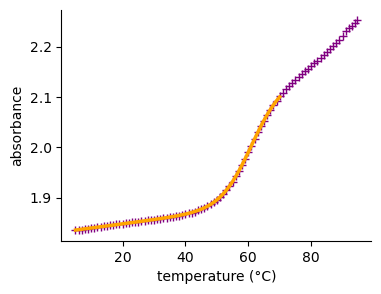

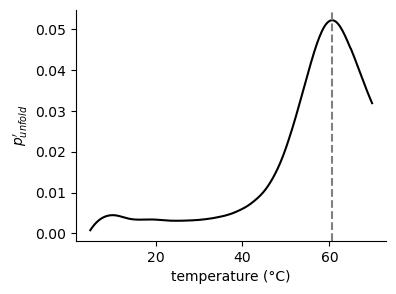

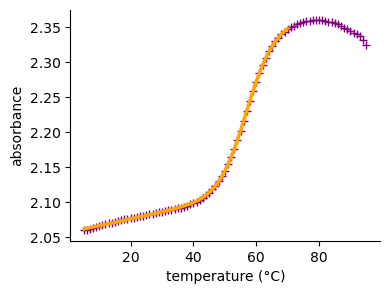

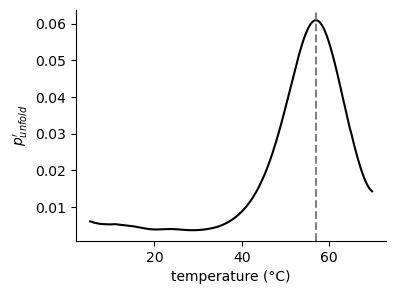

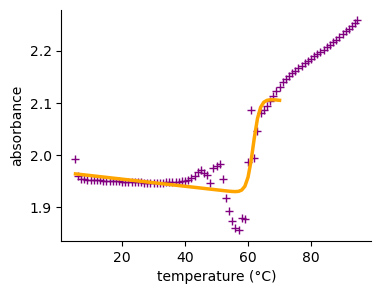

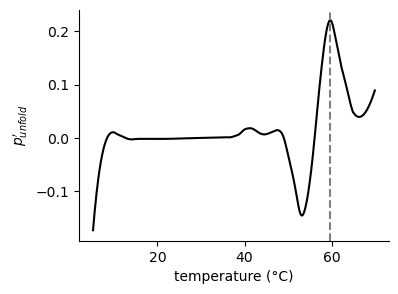

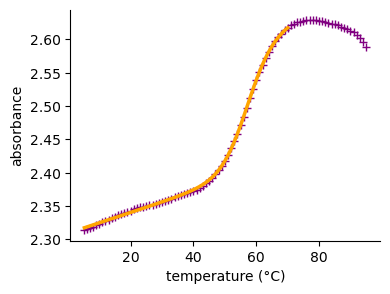

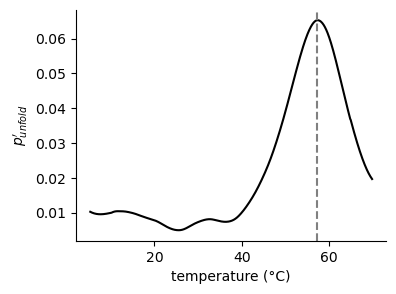

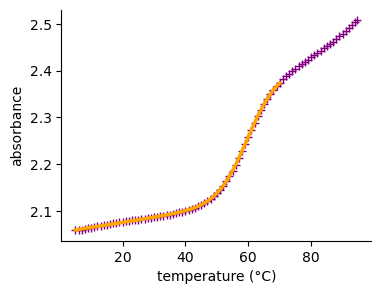

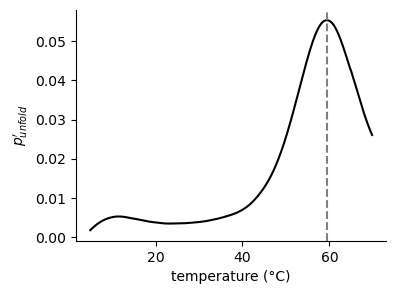

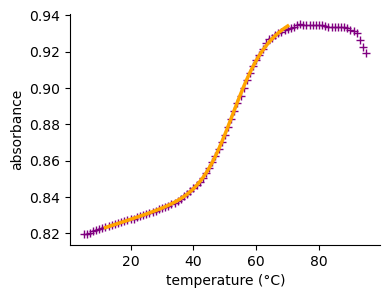

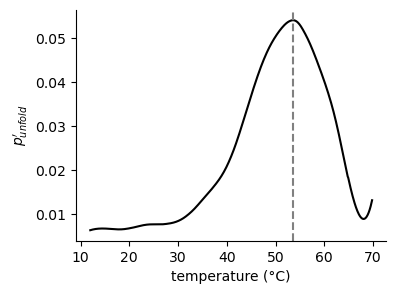

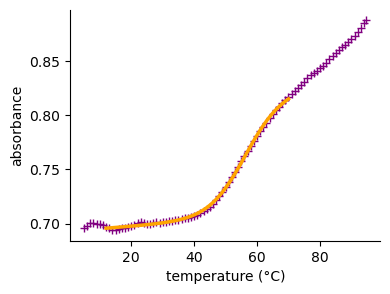

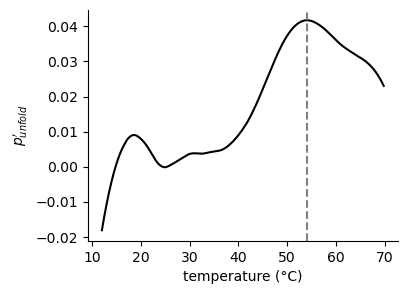

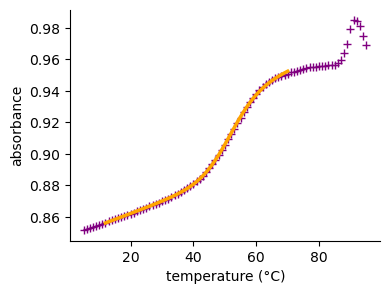

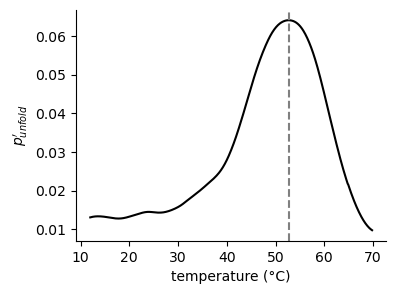

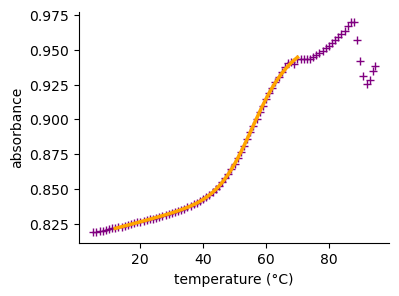

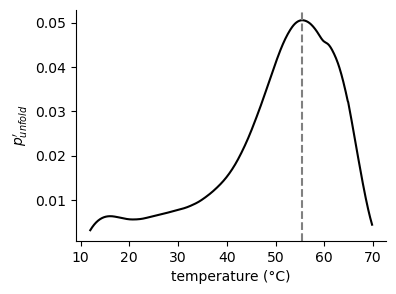

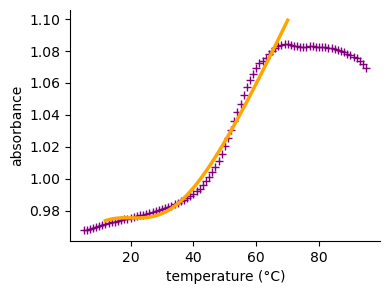

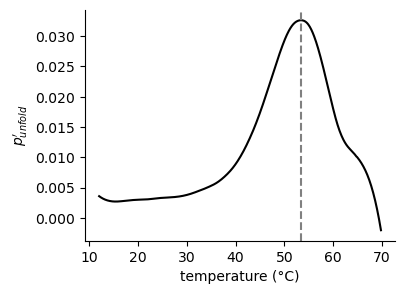

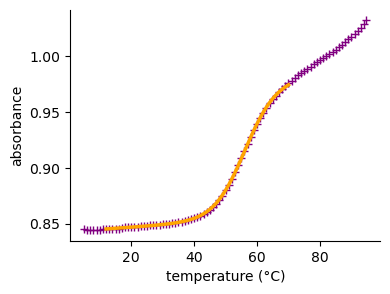

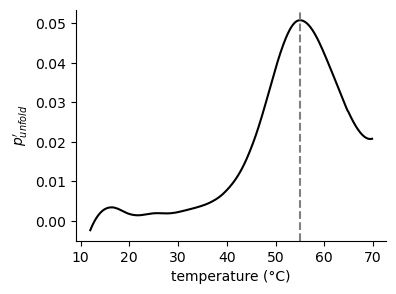

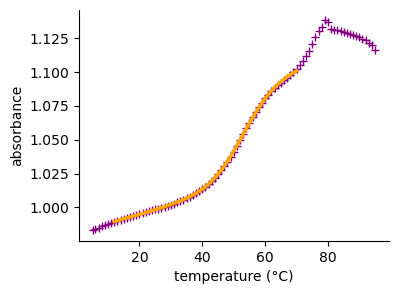

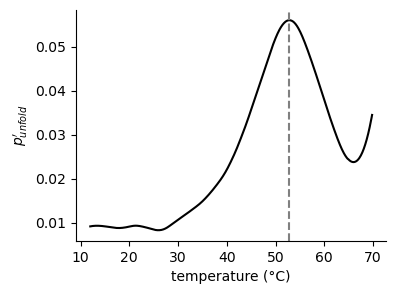

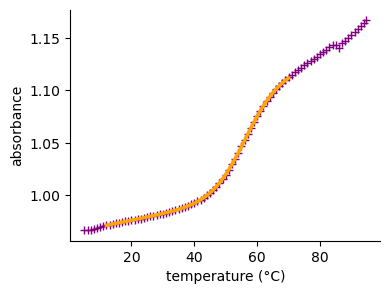

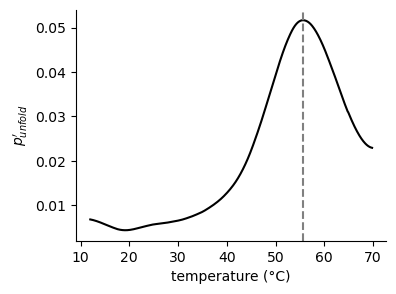

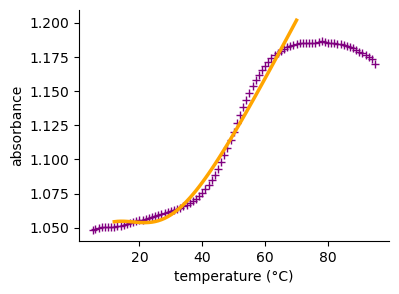

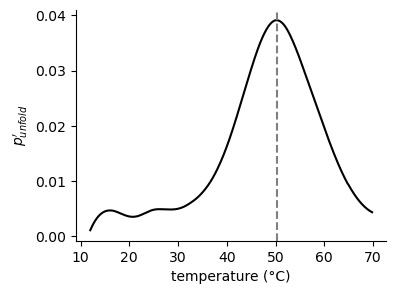

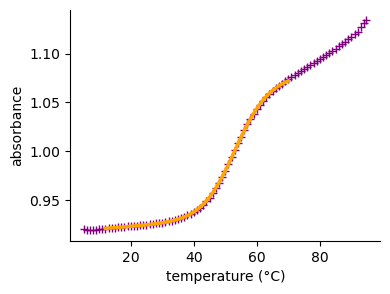

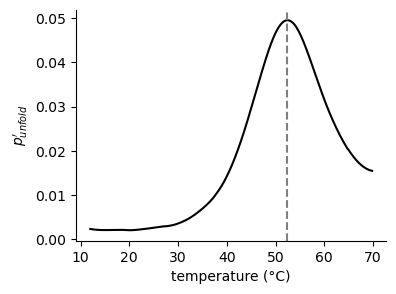

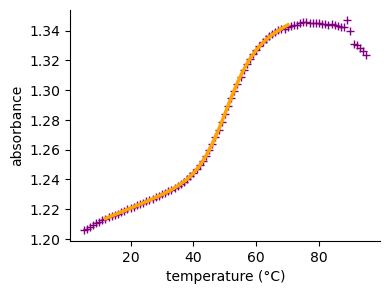

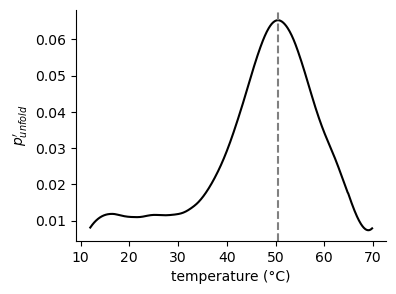

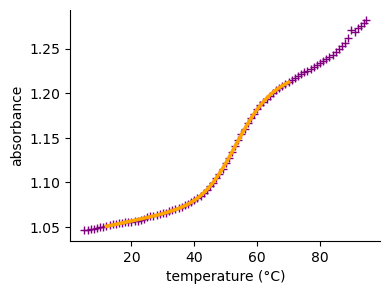

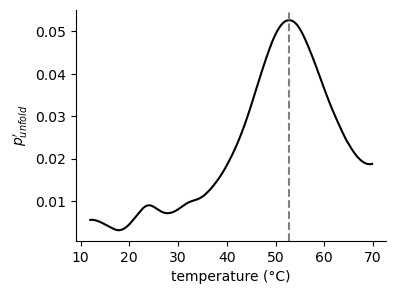

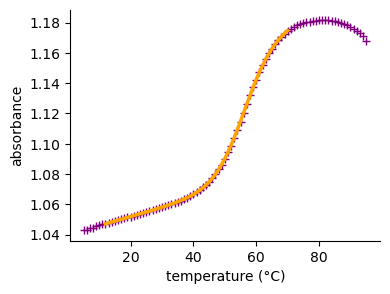

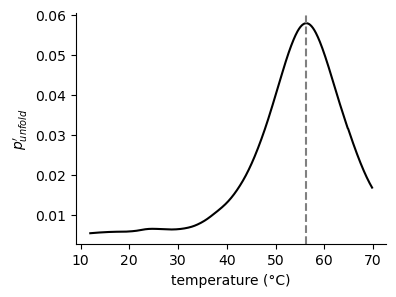

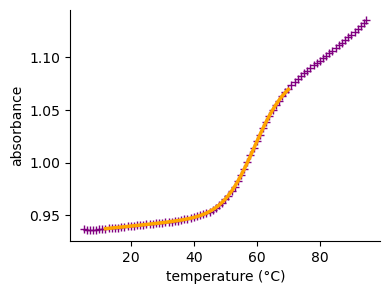

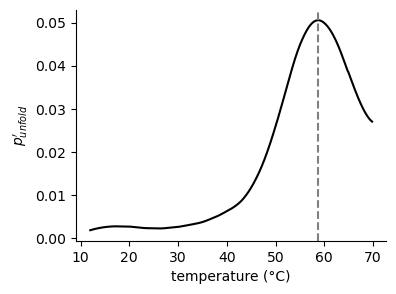

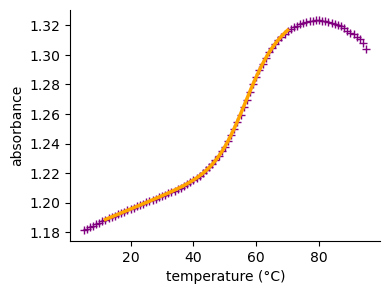

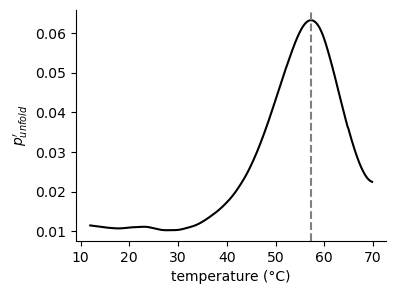

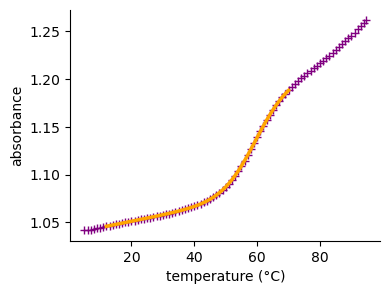

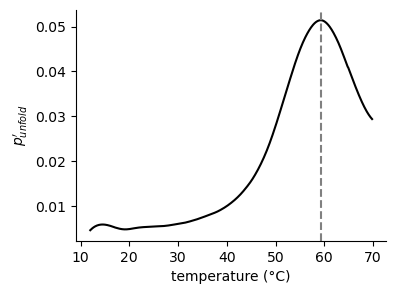

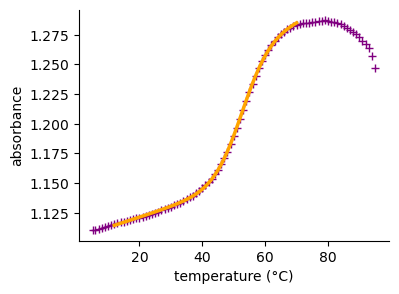

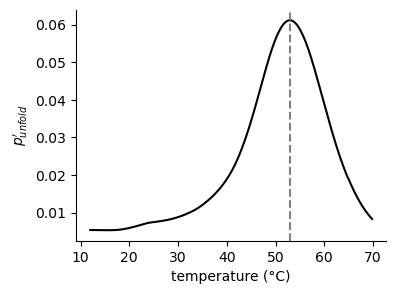

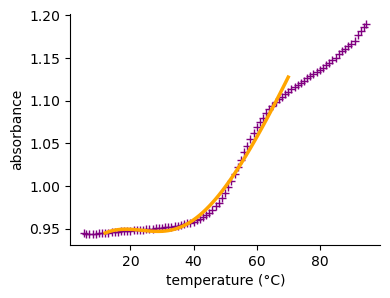

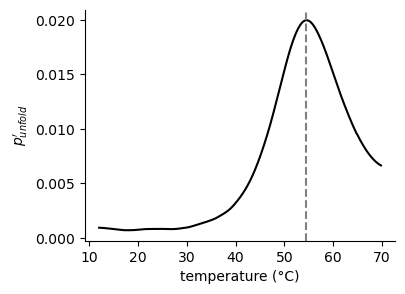

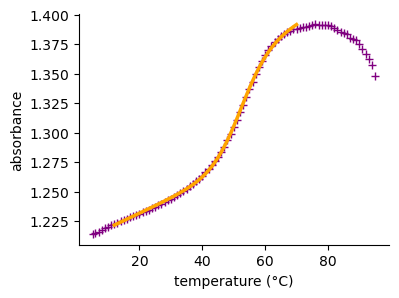

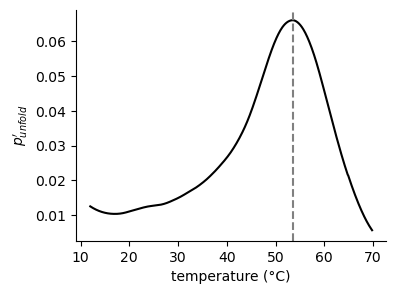

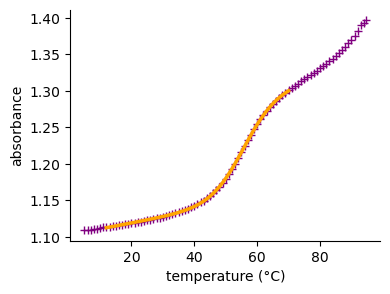

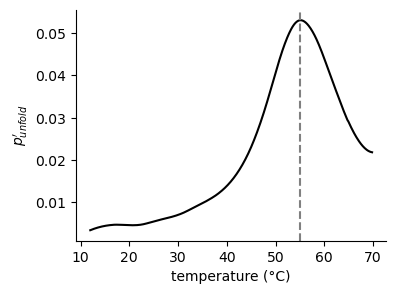

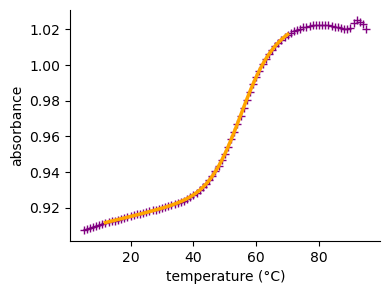

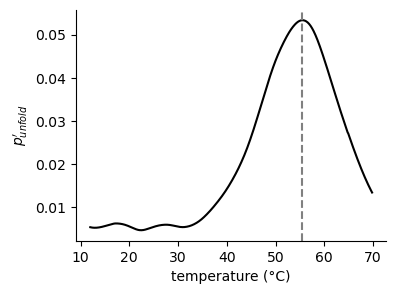

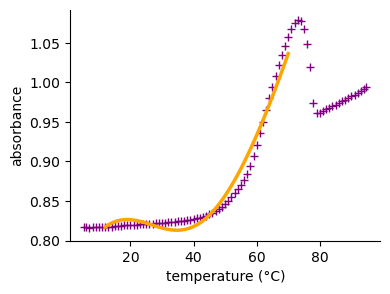

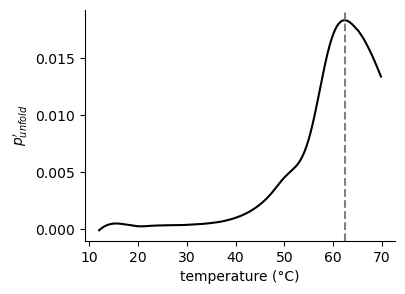

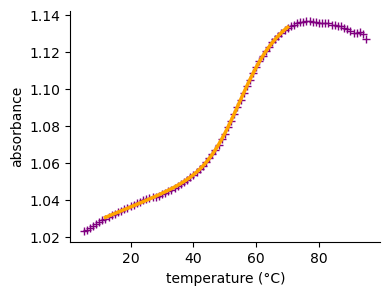

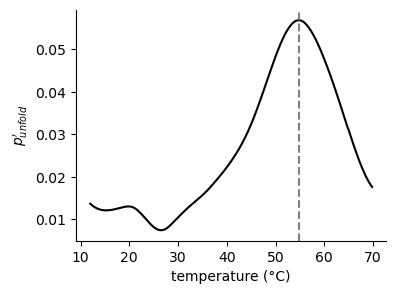

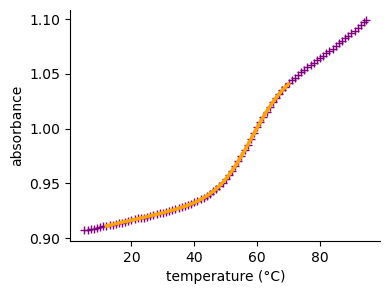

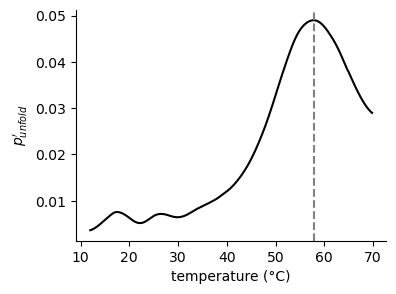

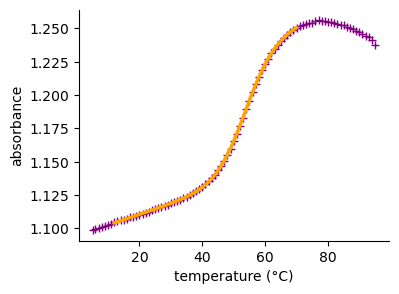

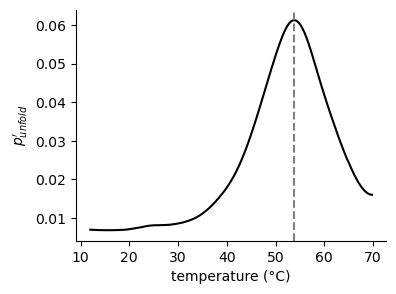

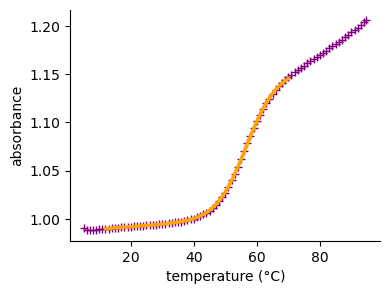

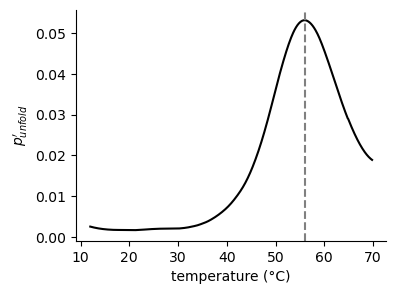

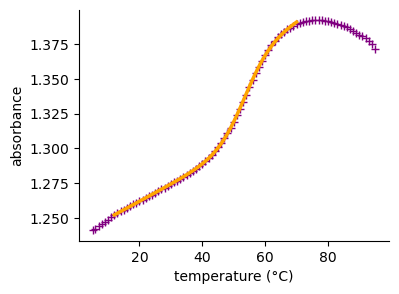

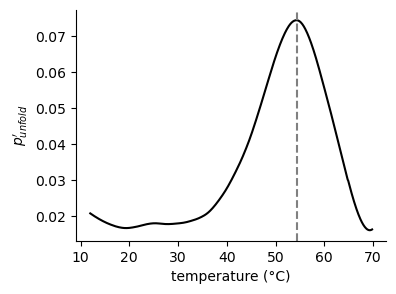

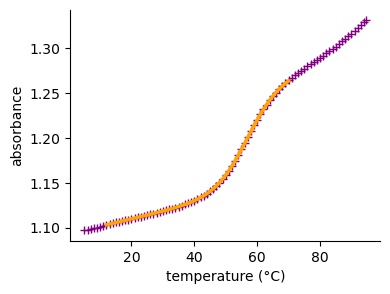

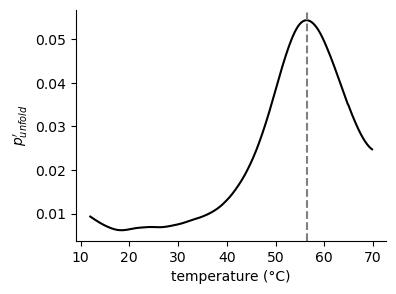

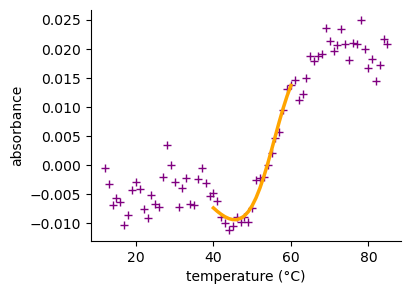

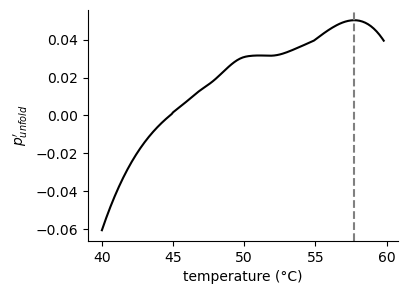

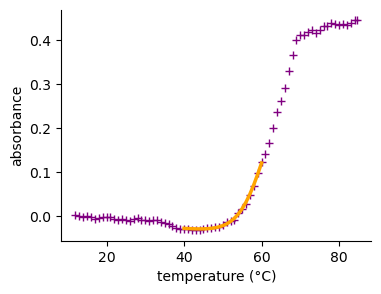

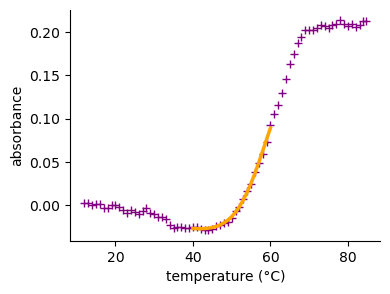

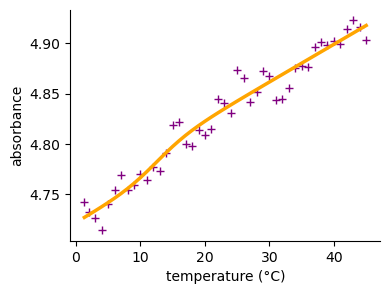

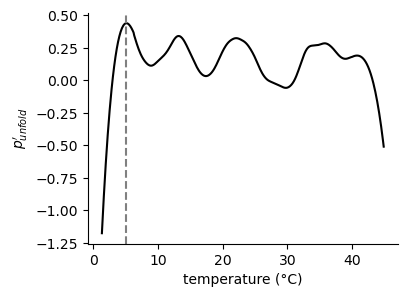

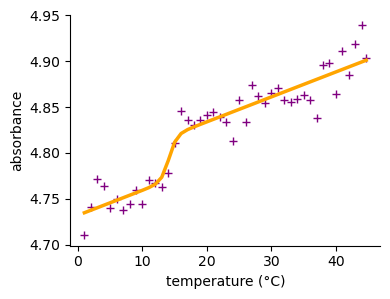

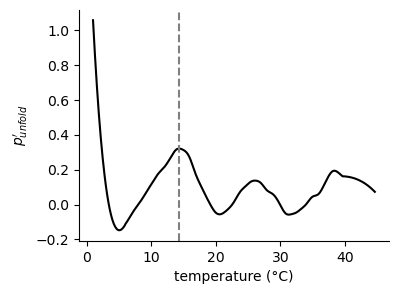

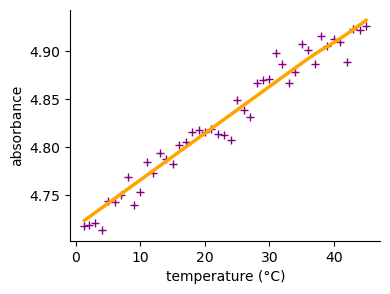

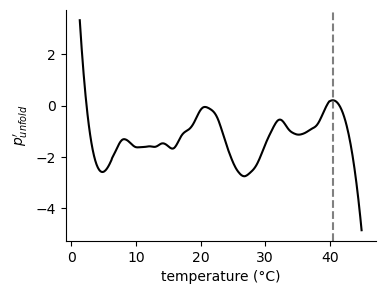

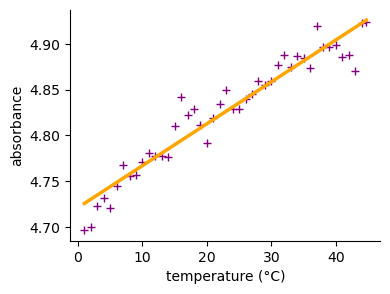

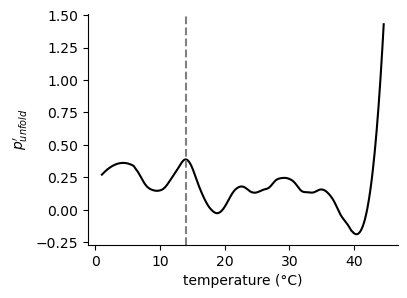

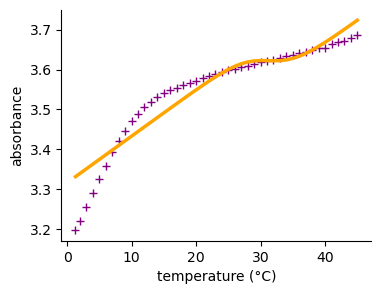

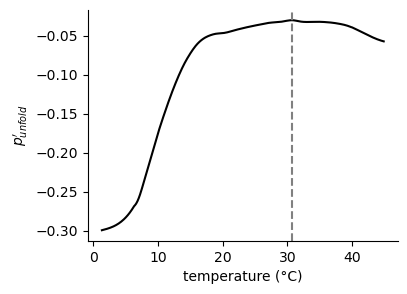

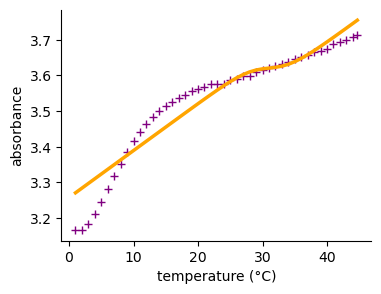

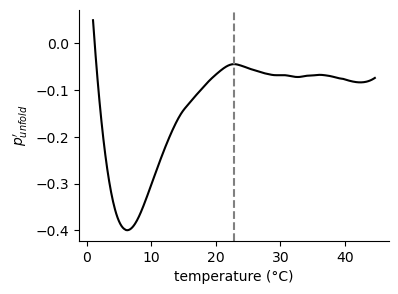

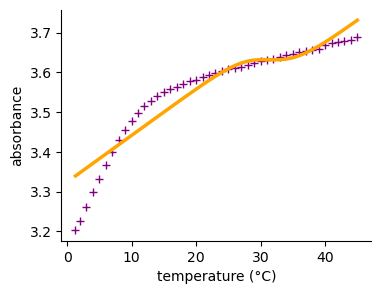

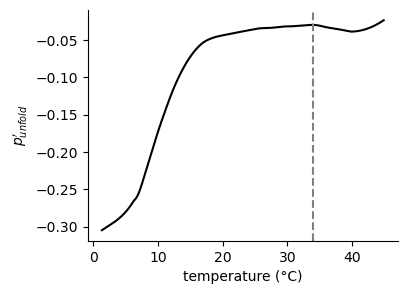

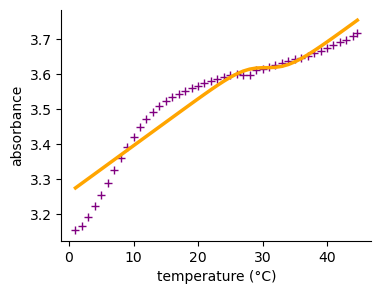

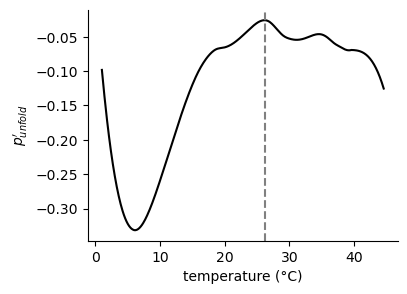

In [139]:
from tqdm import tqdm
result_columns = ['curve_date', 'curve_num', 'curve_name',
                  'dH_fit', 'dH_fit_std', 'Tm_fit', 'Tm_fit_std', 
                  'fmax_fit', 'fmax_fit_std', 'fmin_fit', 'fmin_fit_std', 
                  'slope_fit', 'slope_fit_std', 
                  'Tm', 'dH', 'dS', 'dG_37', 
                  'celsius_min', 'celsius_max']

result_df = pd.DataFrame(index=[parse_curve_name(x)['curve_str'] for x in data_list], columns=result_columns)

for fn in data_list:
    curve_name = parse_curve_name(fn)
    row = sample_df.query("curve_date == '%s' & curve_num == '%s'" % (curve_name['curve_date'], curve_name['curve_num']))
    
    if row.shape[0] == 0:
        print('Cannot find %s in the sample sheet' % fn)
    else:
        result_dict = fit_curve(fn, figdir='/mnt/d/data/nnn/fig', 
                                celsius_min=row.at[row.index[0],'celsius_min'],
                                celsius_max=row.at[row.index[0],'celsius_max'])

        result_df.loc[curve_name['curve_str'], :] = result_dict
result_df.to_csv('/mnt/d/data/nnn/uvmelt.csv')

In [142]:
result_df = result_df.dropna()

In [145]:
result_df.join(sample_df, rsuffix='_anno')

curve_date curve_num             curve_name  \
220526_1_CoolingCurve              220526         1           CoolingCurve   
220526_1_MeltingCurve              220526         1           MeltingCurve   
220526_2_CoolingCurve              220526         2           CoolingCurve   
220526_2_MeltingCurve              220526         2           MeltingCurve   
220712_4_CoolingCurve              220712         4           CoolingCurve   
...                                   ...       ...                    ...   
221013_1_MeltingCurve              221013         1           MeltingCurve   
221013_2_CoolingCurve              221013         2           CoolingCurve   
221013_2_MeltingCurve              221013         2           MeltingCurve   
221013_2_SecondaryCoolingCurve     221013         2  SecondaryCoolingCurve   
221013_2_SecondaryMeltingCurve     221013         2  SecondaryMeltingCurve   

                                    dH_fit  dH_fit_std     Tm_fit Tm_fit_std  \
220526_1_CoolingCurve           -30.368495    0.677792   27.01489   0.065785   
220526_1_MeltingCurve            -20.95992       1.269  29.682483   0.173577   
220526_2_CoolingCurve           -32.389623     1.75372   18.61266   0.235013   
220526_2_MeltingCurve           -20.417895    1.590961  24.265625   0.287461   
220712_4_CoolingCurve            -56.19588    0.573971   67.90783   0.050439   
...                                    ...         ...        ...        ...   
221013_1_MeltingCurve          -280.840046  207.897594  14.115039   0.465182   
221013_2_CoolingCurve           -75.268982     65.2572  31.272028   1.930892   
221013_2_MeltingCurve           -90.525327  110.824261  31.041039   2.358363   
221013_2_SecondaryCoolingCurve  -73.846966   64.147074   31.40822   1.971037   
221013_2_SecondaryMeltingCurve  -90.749208   96.038213   30.60956   2.007036   

                                fmax_fit fmax_fit_std  fmin_fit  ...  \
220526_1_CoolingCurve           0.309977     0.000802  0.280776  ...   
220526_1_MeltingCurve           0.330802     0.005812  0.274305  ...   
220526_2_CoolingCurve           0.134697     0.000298  0.125953  ...   
220526_2_MeltingCurve           0.147056     0.002091  0.126341  ...   
220712_4_CoolingCurve           4.185157     0.002606  3.792917  ...   
...                                  ...          ...       ...  ...   
221013_1_MeltingCurve           4.779512     0.007742  4.732019  ...   
221013_2_CoolingCurve           3.196469     0.146461  3.315692  ...   
221013_2_MeltingCurve           3.166057      0.06261  3.257767  ...   
221013_2_SecondaryCoolingCurve  3.202884      0.10831  3.324187  ...   
221013_2_SecondaryMeltingCurve  3.154446     0.063691  3.261711  ...   

                                   dG_37 celsius_min celsius_max  \
220526_1_CoolingCurve           1.480702           5          60   
220526_1_MeltingCurve           0.477899           5          60   
220526_2_CoolingCurve           2.191719           5          60   
220526_2_MeltingCurve           0.849691           5          60   
220712_4_CoolingCurve          -5.315067           5          80   
...                                  ...         ...         ...   
221013_1_MeltingCurve           16.63318           0          45   
221013_2_CoolingCurve           -0.45822           0          45   
221013_2_MeltingCurve          -1.478075           0          45   
221013_2_SecondaryCoolingCurve  -0.22706           0          45   
221013_2_SecondaryMeltingCurve -0.664281           0          45   

                               curve_date_anno curve_num_anno SEQID conc_uM  \
220526_1_CoolingCurve                      NaN            NaN   NaN     NaN   
220526_1_MeltingCurve                      NaN            NaN   NaN     NaN   
220526_2_CoolingCurve                      NaN            NaN   NaN     NaN   
220526_2_MeltingCurve                      NaN            NaN   NaN     NaN   
220712_4_CoolingCurve                      NaN          

In [146]:
sample_df.index = 

curve_date curve_num         SEQID conc_uM Na_mM celsius_min celsius_max
0      220526         1         SL001       4  1000           5          60
1      220526         2         SL001       2  1000           5          60
2      220526         3         SL001       1  1000           5          60
3      220526         4         SL001     0.5  1000           5          60
4      220712         1        WC2378     128  1000           5          80
5      220712         2        WC2378      64  1000           5          80
6      220712         3        WC2378      32  1000           5          80
7      220712         4        WC2378      16  1000           5          80
8      220712         5        WC2378       8  1000           5          80
9      220712         6        WC2378       4  1000           5          80
10     220712         7        WC2378       2  1000           5          80
11     220727         1          WC68       1  1000          20          95
12     220727         2          WC68       2  1000          20          95
13     220727         3          WC68       4  1000          20          95
14     220727         4          WC68       5  1000          20          95
15     220727         5          WC68       8  1000          20          95
16     220727         6          WC68      10  1000          20          95
17     220727         7          WC68      12  1000          20          95
18     220809         1        WC1106     6.4  1000           5          85
19     220809         2        WC1048     6.4  1000           5          85
20     220809         3        WC1394     6.4  1000           5          85
21     220809         4         WC200     6.4  1000           5          85
22     220809         5         WC578     6.4  1000           5          85
23     220809         6        WC1025     6.4  1000           5          85
24     220809         7        WC1154     6.4  1000           5          85
25     220828         1        WC1048     6.4    50           5          70
26     220828         2        WC1394     6.4    50           5          70
27     220828         3         WC200     6.4    50           5          70
28     220828         4         WC578     6.4    50           5          70
29     220828         5        WC1025     6.4    50           5          70
30     220828         6        WC1154     6.4    50           5          70
31     220828         7         WC788     6.4    50           5          70
32     220904         1        WC1048     3.2    25          12          70
33     220904         2        WC1394     3.2    25          12          70
34     220904         3         WC200     3.2    25          12          70
35     220904         4         WC578     3.2    25          12          70
36     220904         5        WC1025     3.2    25          12          70
37     220904         6        WC1154     3.2    25          12          70
38     220904         7         WC788     3.2    25          12          70
39     220908         1         WC788     3.2    25          40          60
40     220908         2        WC1432     3.2    25          40          60
41     220908         3        WC1203     3.2    25          40          60
42     220908         4        WC2922     3.2    25          40          60
43     220908         5          WC91     3.2    25          40          60
44     220908         6        WC2119     3.2    25          40          60
45     220908         7        WC2215     3.2    25          40          60
46     221013         1   WC1025_stem      48    25           0          45
47     221013         2   WC1025_stem      72    25           0          45
48     221013         3   WC1025_stem      96    25           0          45
49     221013         4  WC1025_split      48    25           0          45
50     221013         5  WC1025_split      72    25           0          45
51     221013         6  WC1025_split      96    25